In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

## Data Cleaning

In [2]:
df = pd.read_csv('CPITimeSeries.csv',sep=',',header=0)

C:\Users\esrpi\AppData\Local\Temp\ipykernel_19540\2354858438.py:1: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,25

In [3]:
df = df.drop(df[df["Indicator Code"] != "PCPI_IX"].index)
df = df.drop(df[df["Attribute"] != "Value"].index)
df = df.drop(['Indicator Name','Common Reference Period','Unnamed: 878'],axis=1)
df = df.drop(columns = ["Indicator Code","Attribute"])
df = df.reset_index(drop=True)

years_to_drop = []
for y in range(40):
    for m in range(12):
        years_to_drop.append(f'19{50+y}M{m+1}')

df = df.drop(years_to_drop,axis=1)
df.head()

,Country Name,Country Code,1990M1,1990M2,1990M3,1990M4,1990M5,1990M6,1990M7,1990M8,...,2021M11,2021M12,2022M1,2022M2,2022M3,2022M4,2022M5,2022M6,2022M7,2022M8
0,Brazil,223,0.005410857,0.009508499,0.01734255,0.02003411,0.0215547,0.02408738,0.02719947,0.03070276,...,6075.69,6120.04,6153.09,6215.24,6315.93,6382.88,6412.88,6455.85,6411.95,NaN
1,France,132,66.42,66.56,66.72,67.09,67.19,67.18,67.2,67.64,...,107.64,107.85,108.12,108.94,110.49,110.97,111.72,112.55,112.87,113.29
2,Bulgaria,918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7659.2699399122,7728.99879117314,7841.08640403034,7954.55523691129,8131.17796924526,8331.52722236692,8432.65279081599,8506.69398844988,8601.91208943529,8702.17132815588
3,Honduras,268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,365,368.5,373,374.3,377.8,384.2,387.6,392.7,396.2,396.1
4,Colombia,233,5.967753,6.191108,6.372583,6.547079,6.679696,6.805333,6.89607,7.007748,...,110.6031,111.4066,113.2623,115.1129,116.2593,117.7089,118.7032,119.3053,120.2736,121.5025


In [5]:
# find countries whose alias are obscured
[s for s in df["Country Name"].to_list() if "Ukraine" in s]

['Ukraine']

In [4]:
def get_ts(country_name,chop=0):
    index = pd.period_range('1990-01','2022-08',freq='M')

    vals = df[df['Country Name'] == country_name].drop(["Country Name","Country Code"],axis=1).to_numpy()[0]

    res = pd.Series(data=vals,index=index,dtype=np.float64,name=country_name)

    if chop>0:
        res = res[:-chop]

    return res

Text(0.5, 0, 'Time (Year-Month)')

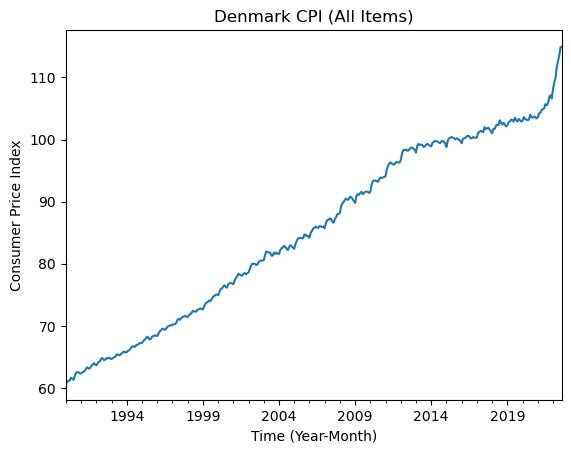

In [5]:
ts = get_ts('Denmark')

plt.figure()
ax = ts.plot()
ax.set_title('Denmark CPI (All Items)')
ax.set_ylabel('Consumer Price Index')
ax.set_xlabel('Time (Year-Month)')

The TS has a clear trend and seems to present a yearly seasonality

## TS splitting

In [6]:
def split_ts(ts, n=12):
    return ts[:-n], ts[-n:]

Text(0.5, 0, 'Time (Year-Month)')

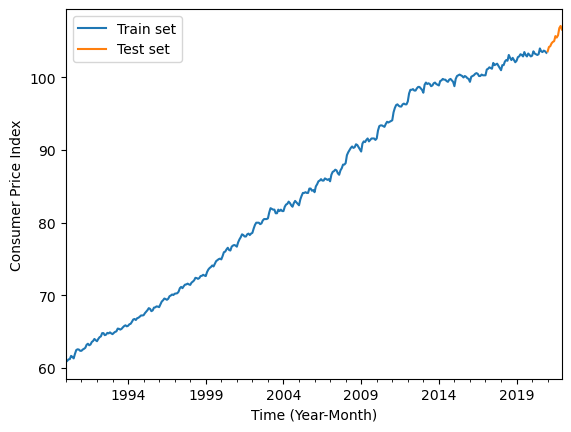

In [31]:
ts_train, ts_test = split_ts(ts[:-8])

ts_train.name = "Train set"
ts_test.name = "Test set"

#with plt.style.context(['science','ieee']):

fig = plt.figure()
ax = ts_train.plot(legend=True)
ts_test.plot(ax=ax,legend=True)
ax.set_ylabel('Consumer Price Index')
ax.set_xlabel('Time (Year-Month)')

    #plt.savefig('figs/cpi.pdf')
#plt.close()

## Basic description tecnhiques & transformations

##### Polynomial Fitting

MSE (Linear):0.0002467629913901366
MSE (Quadratic):0.00024349256497189852
MAE (Linear):0.012424800301562065
MAE (Quadratic):0.013051052455642736


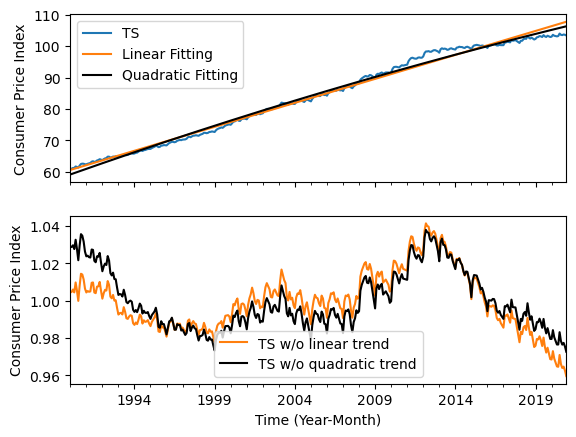

In [17]:
ts_train.name = 'TS' # reset name for plotting purposes

n = np.array(range(len(ts_train)))

coefs = np.polyfit(n,ts_train.values,1)
vals = np.polyval(coefs,n)
lin_ts=pd.Series(vals,index=ts_train.index,name="Linear Fitting")

coefs = np.polyfit(n,ts_train.values,2)
vals = np.polyval(coefs,n)
quad_ts=pd.Series(vals,index=ts_train.index,name="Quadratic Fitting")

fig, (ax1, ax2) = plt.subplots(2,sharex=True)

ts_train.plot(ax=ax1,legend=True)
lin_ts.plot(ax=ax1,legend=True)
quad_ts.plot(ax=ax1,legend=True, color='k')
ax1.set_ylabel('Consumer Price Index')
ax1.set_xlabel('Time (Year-Month)')

# removing linear trend
nolin_ts = ts_train/lin_ts
nolin_ts.name = "TS w/o linear trend"
ax2 = nolin_ts.plot(legend=True,color='tab:orange')
ax2.set_ylabel('Consumer Price Index')
ax2.set_xlabel('Time (Year-Month)')

# removing quadratic trend
#plt.figure()
noquad_ts = ts_train/quad_ts
noquad_ts.name = "TS w/o quadratic trend"
noquad_ts.plot(ax=ax2,legend=True,color='k')
#ax2.set_ylabel('Consumer Price Index')
#ax2.set_xlabel('Time (Year-Month)')

#plt.savefig('figs/diff.pdf')
print(f'MSE (Linear):{np.mean((nolin_ts - 1)**2)}')
print(f'MSE (Quadratic):{np.mean((noquad_ts - 1)**2)}')
print(f'MAE (Linear):{np.mean(np.abs(nolin_ts - 1))}')
print(f'MAE (Quadratic):{np.mean(np.abs(noquad_ts - 1))}')

Concerning the independence of the seasonality and erratic components from the trend, a multiplicative mode is better suited. The quadratic model seems to model better the increasing trend, as the peaks circa 1900-1994 and 2002-2004 are not well captured by the linear trend.

##### Moving-Average Local Smoothing

C:\Users\esrpi\AppData\Local\Temp\ipykernel_19540\3680167205.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TSeriesAug=TSeries.append(np.flip(TSeries[-lag:]))
C:\Users\esrpi\AppData\Local\Temp\ipykernel_19540\3680167205.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  TSeriesAug=np.flip(TSeries[0:lag]).append(TSeriesAug)


MSE: 1.2990637880195763e-05
MEA: 0.002889429581334751


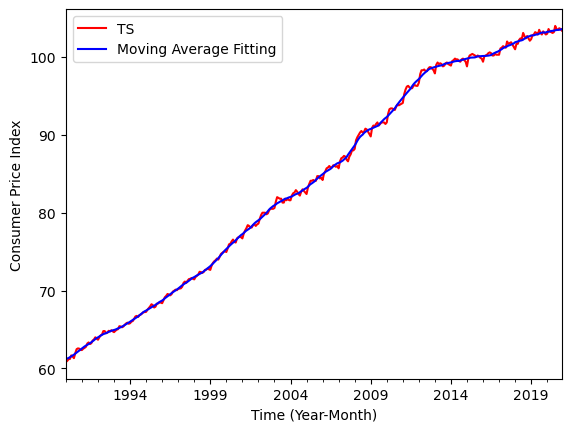

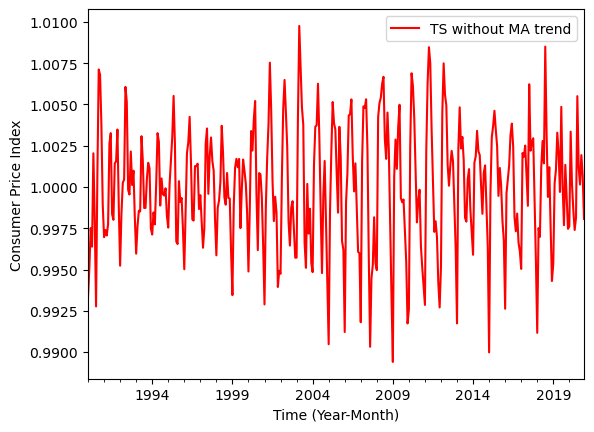

In [21]:
def maSmooth(TSeries,omega,data_aug=False):
    M=omega.shape[0]
    lag=int(np.floor((M-1)/2))
    
    if data_aug: #If smooted TS should have the same number of samples
        TSeriesAug=TSeries.append(np.flip(TSeries[-lag:]))
        TSeriesAug=np.flip(TSeries[0:lag]).append(TSeriesAug)
        
    else:
        TSeriesAug=TSeries
        
    nf=range(lag,TSeriesAug.size-lag)
    xf=np.zeros(TSeriesAug.size-2*(lag)).astype('float')
    for n in nf:
        xf[n-lag]=(1/float(sum(omega)))*np.sum(np.multiply(TSeriesAug[n-lag:n+lag+1],omega))
    xf=pd.Series(data=xf, index=TSeriesAug.index[lag:TSeriesAug.size-lag],name="Moving Average Fitting")
    
    return xf

M=13
omega=np.ones(M)*(1/float(M))
ma_smooth=maSmooth(ts_train,omega,data_aug=True)

#with plt.style.context('science'):

plt.figure()
ax=ts_train.plot(legend=True,color='r')
ma_smooth.plot(ax=ax,legend=True,color='b')
ax.set_ylabel('Consumer Price Index')
ax.set_xlabel('Time (Year-Month)')

plt.figure()
nomasmooth_ts = ts_train/ma_smooth
nomasmooth_ts.name = "TS without MA trend"
ax=nomasmooth_ts.plot(legend=True,color='r')
ax.set_ylabel('Consumer Price Index')
ax.set_xlabel('Time (Year-Month)')
 

print(f'MSE: {np.mean((nomasmooth_ts - 1)**2)}')
print(f'MEA: {np.mean(np.abs(nomasmooth_ts - 1))}')

The figures show that the local smoothing approach is actually better at removing the trend than the polynomial approaches

##### LOcally WEighted Scatter plot Smooth (LOWESS)

MSE:1.0875666201485721e-05
MEA: 0.002575292939107729


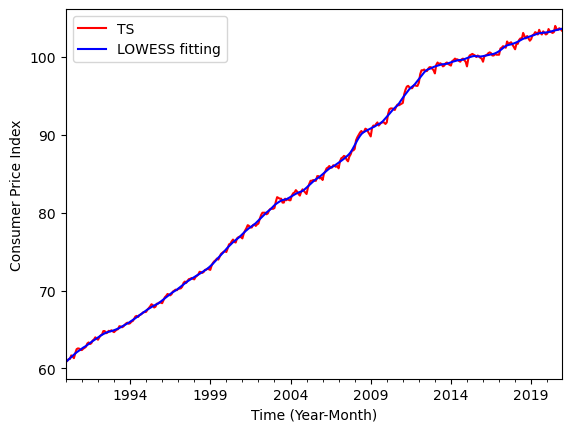

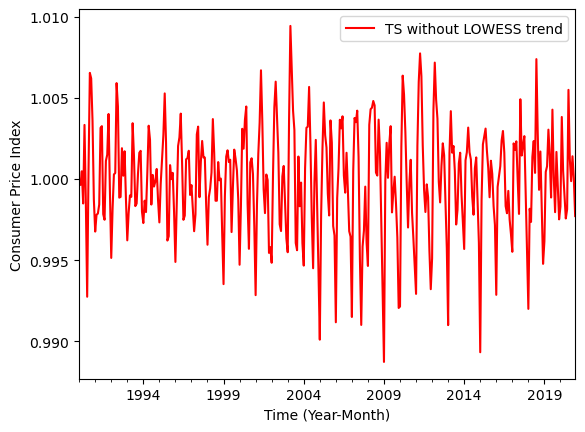

In [22]:
import statsmodels.api as sm
from scipy.optimize import curve_fit

def flin(x,a,b):
    return a*x+b

def xWeights(x,xi,span):
    wi=(1-abs((x-xi)/float(span))**3)**3
    #plt.figure()
    #plt.plot(wi)
    return wi

def yWeights(ri,MAD):
    if np.abs(ri)<6*MAD:
        return (1-((ri/(6*MAD))**2))**2
    else:
        return 0


def loessPass(TSeries,TSeriesE=pd.Series(np.array([])),span=5,timePass=True):
    lag=int((span-1)/2)
    xf=np.zeros(TSeries.size).astype('float')
    for k in range(TSeries.size):
        if k<=lag:
            win=TSeries[0:span]
            if not timePass:
                winE=TSeriesE[0:span]
            xvs=np.array(range(span))
            #print "No inicio"
        elif k>TSeries.size-lag:
            #print "No fim"
            win=TSeries[TSeries.size-span:TSeries.size]
            if not timePass:
                winE=TSeriesE[TSeriesE.size-span:TSeriesE.size]
            xvs=np.array(range(TSeries.size-span,TSeries.size))
        else:
            #print "No meio"
            win=TSeries[k-lag-1:k+lag]
            if not timePass:
                winE=TSeriesE[k-lag-1:k+lag]
            xvs=np.array(range(k-lag,k+lag+1))

        ws=np.zeros(span).astype('float')
            
        if not timePass:
            res=np.array(win-winE)
            #res=res.as_matrix()
            MAD=np.median(np.abs(res))
            
        for xw in range(len(xvs)):
            if timePass:
                ws[xw]=xWeights(k,xvs[xw],np.max((np.abs(k-xvs[0]),np.abs(k-xvs[-1]))))
            else:
                ws[xw]=yWeights(res[xw],MAD)
            #print np.max((np.abs(k-xvs[0]),np.abs(k-xvs[-1])))
        exog = sm.add_constant(xvs)
        
        
        mod_wls = sm.WLS(win, exog, weights=ws)
        res_wls = mod_wls.fit()
        
        xf[k]=res_wls.params[1]*k+res_wls.params[0]
    return xf

def lowess(TSeries,span=5,ftype='linear'):
    
    xf=loessPass(TSeries,span=span,timePass=True)
    xf=loessPass(TSeries,TSeriesE=pd.Series(data=xf, index=TSeries.index),span=span,timePass=False)
    xf=pd.Series(data=xf, index=TSeries.index,name="Lowess Fitting")
    return xf

from statsmodels.nonparametric.smoothers_lowess import lowess as lw

lowess_smooth = pd.Series(
    data=lw(ts_train.values, np.arange(len(ts_train.index)), frac=(13.1/275), it=1)[:,1], # 13,1 because lowess uses a fraction of the data as time window, and f=13,1/275 assures that f*275~13 instead of ~12 
    index=ts_train.index,
    name='LOWESS fitting')
    
#lowess_smooth=lowess(ts_train,span=13)

#with plt.style.context('science'):

plt.figure()
ax=ts_train.plot(legend=True,color='r')
lowess_smooth.plot(ax=ax,legend=True,color='b')
ax.set_ylabel('Consumer Price Index')
ax.set_xlabel('Time (Year-Month)')

plt.figure()
nolowesssmooth_ts = ts_train/lowess_smooth
nolowesssmooth_ts.name = "TS without LOWESS trend"
ax=nolowesssmooth_ts.plot(legend=True,color='r')
ax.set_ylabel('Consumer Price Index')
ax.set_xlabel('Time (Year-Month)')

# take the MSE
print(f'MSE:{np.mean((nolowesssmooth_ts - 1)**2)}')
print(f'MEA: {np.mean(np.abs(nolowesssmooth_ts - 1))}')

The LOWESS approach seems to equally model the trend. However the $MSE$ taken for all approaches indicate that the MA approach is better at modelling the trend.

Text(0.5, 0, 'Time (Year-Month)')

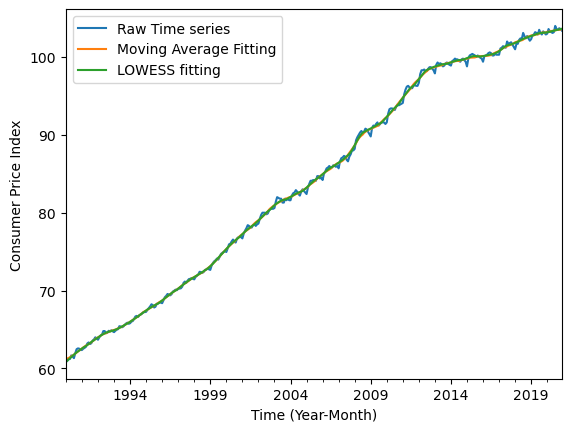

In [27]:
ts_train.name = "Raw Time series"

# with plt.style.context(['science','ieee']):

plt.figure()
ax=ts_train.plot(legend=True)
ma_smooth.plot(ax=ax, legend=True)
lowess_smooth.plot(ax=ax,legend=True)
ax.set_ylabel('Consumer Price Index')
ax.set_xlabel('Time (Year-Month)')

    # plt.savefig('figs/trend.pdf')

##### Seasonality Assessment
First, lets seasonality by fourier transforms, i.e., removing cycles

Text(0.5, 0, 'Time (Year-Month)')

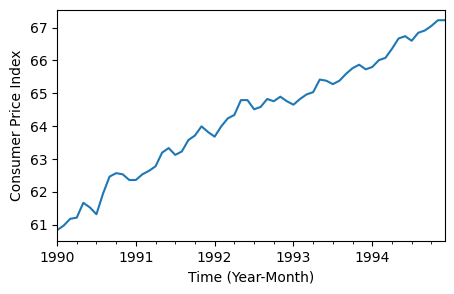

In [29]:
plt.figure(figsize=(5,3))
ax = ts_train[:12*5].plot()
ax.set_ylabel('Consumer Price Index')
ax.set_xlabel('Time (Year-Month)')

It seems that there is a seasonal pattern that repeats every 12 months and an internal pattern every 6 months

Text(0, 0.5, 'Normalized Power Spectrum (A.U:)')

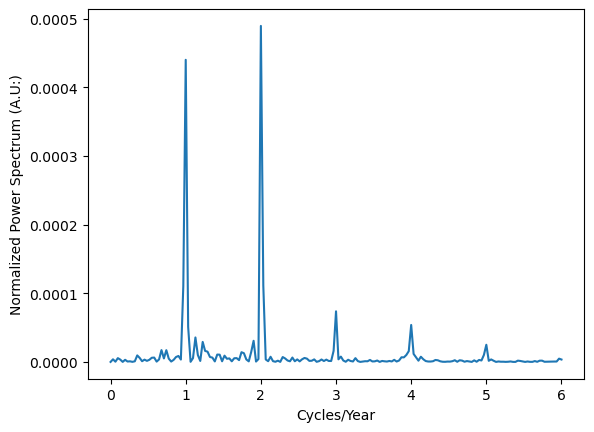

In [32]:
def describe_frequencies(ts, sample_frequency = 12,):
    dft = (np.abs(np.fft.rfft(ts-ts.mean()))**2/ts.size)
    f = np.fft.rfftfreq(ts.size, d=1/sample_frequency)
    return dft, f

dft, f = describe_frequencies(nolowesssmooth_ts)#nomasmooth_ts)

plt.figure()
plt.plot(f,dft)
plt.xlabel("Cycles/Year")
plt.ylabel("Normalized Power Spectrum (A.U:)")

TS appears a little "polluted" with noise, so lets get rid of frequencies below 0.0001

Text(0, 0.5, 'Normalized Power Spectrum (A.U:)')

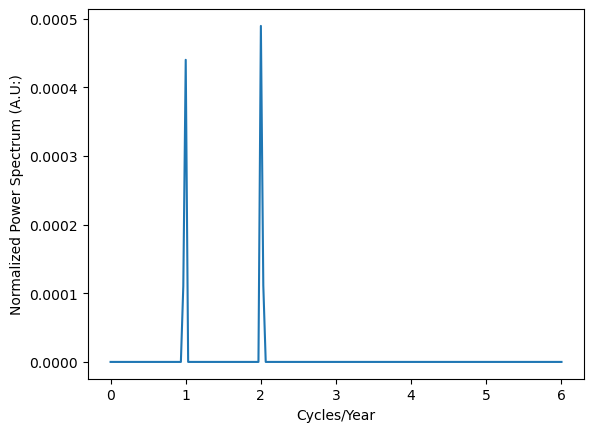

In [33]:
def clean_ft(ft):
    return (ft>0.0001)*ft

plt.figure()
plt.plot(f,clean_ft(dft))
plt.xlabel("Cycles/Year")
plt.ylabel("Normalized Power Spectrum (A.U:)")

It seams as tho the most important component is the one located at 2 cycle/year, so the most important seasonality pattern occurs each 6 months. With this in mind, there is also a clear pattern every year, so we will remove both

Text(0.5, 0, 'Time (Year-Month)')

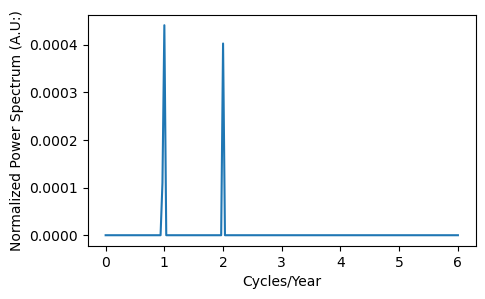

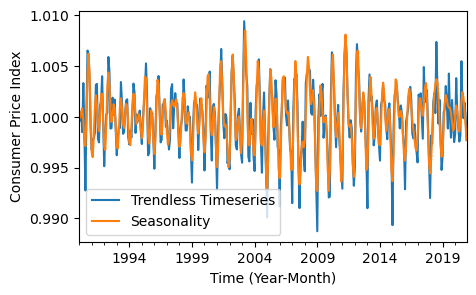

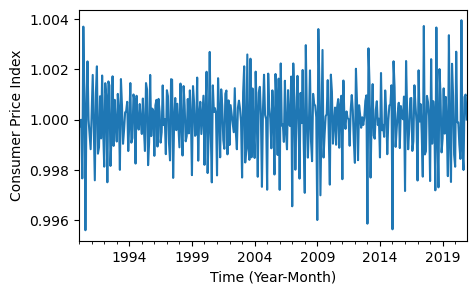

In [34]:
import scipy.signal as scs

#nomasmooth_ts.name = 'Trendless TS'
nolowesssmooth_ts.name = 'Trendless Timeseries'

sos = scs.butter(N=5,fs=12,Wn=[2.4],output='sos')
seasonal = scs.sosfiltfilt(sos,nolowesssmooth_ts)

dft, f = describe_frequencies(seasonal)
plt.figure(figsize=(5,3))
plt.plot(f,clean_ft(dft))
plt.xlabel("Cycles/Year")
plt.ylabel("Normalized Power Spectrum (A.U:)")

# Plot seasonal component
ts_seasonal = pd.Series(seasonal,ts_train.index,name="Seasonality")

plt.figure(figsize=(5,3))
ax = nolowesssmooth_ts.plot(legend=True)
ts_seasonal.plot(ax=ax,legend=True)
ax.set_ylabel('Consumer Price Index')
ax.set_xlabel('Time (Year-Month)')

# Remove seasonal component
erratic_ts = nolowesssmooth_ts/ts_seasonal
erratic_ts.name="Erratic Component"

plt.figure(figsize=(5,3))
ax = erratic_ts.plot()
ax.set_ylabel('Consumer Price Index')
ax.set_xlabel('Time (Year-Month)')

Text(0, 0.5, 'Normalized Power Spectrum (A.U:)')

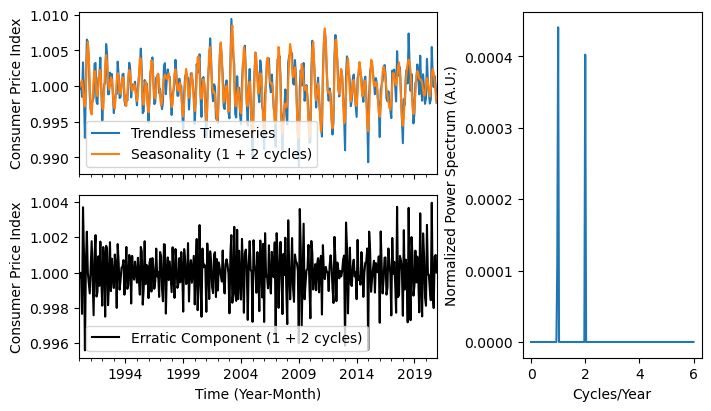

In [37]:
from matplotlib.gridspec import GridSpec

ts_seasonal = pd.Series(seasonal,ts_train.index,name="Seasonality (1 + 2 cycles)")

#with plt.style.context(['science','ieee']):

fig = plt.figure(constrained_layout=True, figsize=(7,4))
gs = GridSpec(2,3, figure=fig)
ax1 = fig.add_subplot(gs[0,0:-1])

nolowesssmooth_ts.plot(ax=ax1,legend=True)
ts_seasonal.plot(ax=ax1,legend=True)
ax1.set_ylabel('Consumer Price Index')
ax1.set_xlabel('Time (Year-Month)')

erratic = nolowesssmooth_ts/ts_seasonal
erratic.name="Erratic Component (1 + 2 cycles)"

ax2 = fig.add_subplot(gs[1,0:-1], sharex=ax1)

erratic.plot(ax=ax2,legend=True, color='k')
ax2.set_ylabel('Consumer Price Index')
ax2.set_xlabel('Time (Year-Month)')

ax3 = fig.add_subplot(gs[:,2])

dft, f = describe_frequencies(seasonal)
ax3.plot(f,clean_ft(dft))
ax3.set_xlabel("Cycles/Year")
ax3.set_ylabel("Normalized Power Spectrum (A.U:)")

#plt.savefig('figs/season.pdf')

##### Differencing
A differencing approach can provide further insights

Text(0.5, 0, 'Time (Year-Month)')

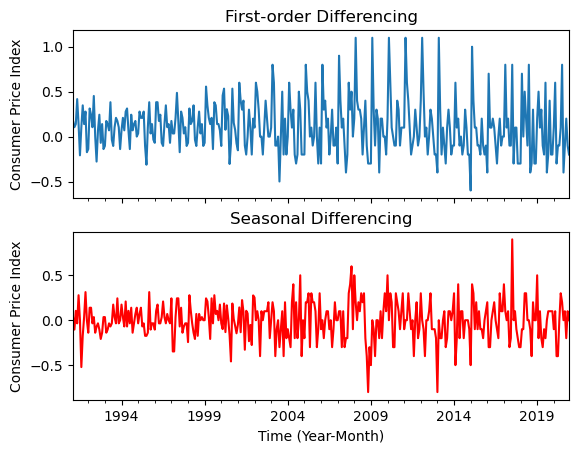

In [39]:
#with plt.style.context(['science','ieee']):

#fig, (ax1, ax2) = plt.subplots(2, figsize=(3.3,3), sharex=True)
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

# First-order differencing
ts_diff_1 = ts_train.diff().dropna()
ts_diff_1.name="First-order Differencing"
ax1.set_title(ts_diff_1.name)
ts_diff_1.plot(ax=ax1)
ax1.set_ylabel('Consumer Price Index')

# Seasonal differencing
ts_diff_2 = ts_diff_1.diff(12).dropna()
ts_diff_2.name="Seasonal Differencing"
ax2.set_title(ts_diff_2.name)
ts_diff_2.plot(ax=ax2, color='r')
ax2.set_ylabel('Consumer Price Index')
ax2.set_xlabel('Time (Year-Month)')

#plt.savefig('figs/differencing.pdf')

##### AutoCorrelation Analysis

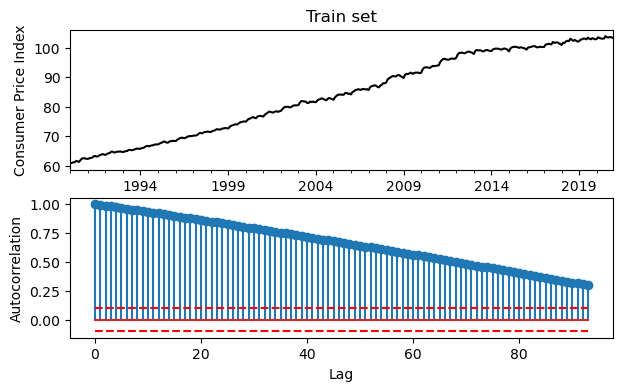

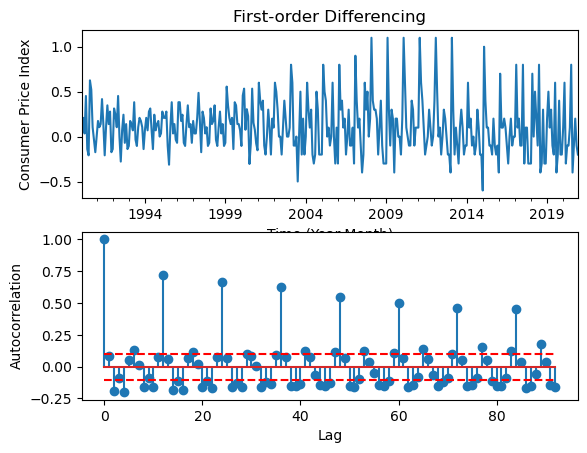

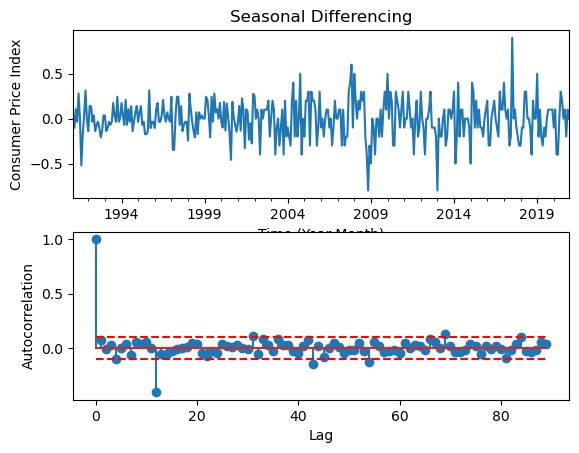

In [40]:
import scipy.stats as spyst


def autocov(timeserie,T=0):
    N=timeserie.size
    mu=timeserie.mean()
    covCoef=0
    for n in range(0,N-T-1):
        covCoef=covCoef+(timeserie[n]-mu)*(timeserie[n+T]-mu)
    return covCoef/float(np.abs(N))
        

def autocoef(timeserie,T=0):
    return autocov(timeserie,T)/autocov(timeserie)

def correlogram(timeserie,maxT,twoside=False):
    N=timeserie.size
    if twoside:
        corrl=np.zeros(2*maxT+1)
        ix=np.array(range(maxT+1))
        ix=np.concatenate((-np.flip(ix[1:]),ix),axis=0)
    else:
        corrl=np.zeros(maxT+1)  
        ix=np.array(range(maxT+1))
    
    for i in range(maxT+1):
        if twoside:
            corrl[i+maxT]=autocoef(timeserie,i);
            if i>0:
                corrl[maxT-i]=corrl[i+maxT]
        else:
            corrl[i]=autocoef(timeserie,i);
    d = {'ACS':corrl, 'upsig':np.ones(maxT+1)*(1.96/np.sqrt(N)),'dnsig':-np.ones(maxT+1)*(1.96/np.sqrt(N))}
    corrl=pd.DataFrame(data=d,index=ix)
    return corrl

def meanvarWtime(timeseries,W=6):
    Nwin=int(np.floor(timeseries.size/W))
    vals=timeseries.to_numpy()
    vals=vals[0:int(Nwin*W)]
    mvals=vals.reshape((Nwin,W))
    return {'mu':np.mean(mvals,axis=1),'var':np.var(mvals,axis=1)}

def plot_acs(ts, ax, name):
    N = ts.size
    corr = correlogram(ts, maxT=int(N/4))
    corr.name = name
    ax.stem(corr.index,corr['ACS'])
    ax.plot(corr.index,corr['upsig'], linestyle='--', color='r', linewidth=1.5)
    ax.plot(corr.index,corr['dnsig'], linestyle='--', color='r', linewidth=1.5)
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")

# Plot ACS for Raw TS

#with plt.style.context(['science','ieee']):

    # plt.rcParams.update({
    #     'lines.markersize': 3
    # })

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7,4))

ts_train.plot(ax=ax1, color='k')
ax1.set_title(ts_train.name)
ax1.set_ylabel('Consumer Price Index')
ax1.set_xlabel('Time (Year-Month)')

plot_acs(ts_train,ax2,'ACS')

#plt.savefig('figs/acs_raw.pdf')

# Plot ACS for 1st-order diff

fig, (ax1, ax2) = plt.subplots(2,1)

ts_diff_1.plot(ax=ax1)
ax1.set_title(ts_diff_1.name)
ax1.set_xlabel('Time (Year-Month)')
ax1.set_ylabel('Consumer Price Index')

plot_acs(ts_diff_1,ax2,'ACS')

#plt.savefig('figs/acs_first.pdf')

fig, (ax1, ax2) = plt.subplots(2,1)

ts_diff_2.plot(ax=ax1)
ax1.set_title(ts_diff_2.name)
ax1.set_ylabel('Consumer Price Index')
ax1.set_xlabel('Time (Year-Month)')

plot_acs(ts_diff_2,ax2,'ACS')
#plt.savefig('figs/acs_seasonal.pdf')

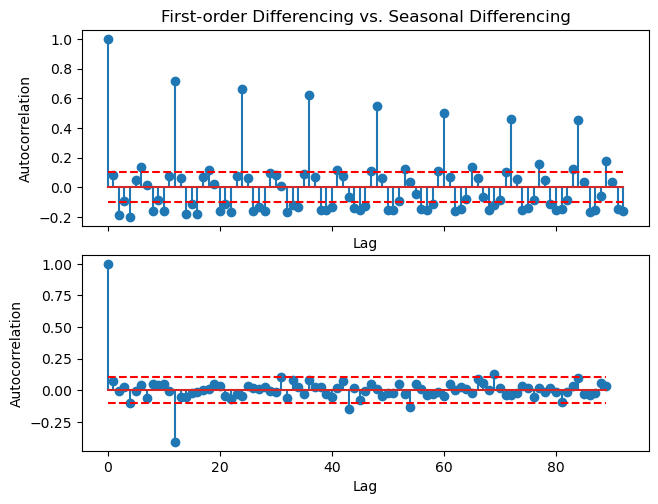

In [44]:
# Plot ACS for 1st-order diff

#with plt.style.context(['science','ieee']):

    # plt.rcParams.update({
    #     'lines.markersize': 2
    # })

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
fig.tight_layout()

ax1.set_title(f'{ts_diff_1.name} vs. {ts_diff_2.name}')
plot_acs(ts_diff_1,ax1,'ACS')
plot_acs(ts_diff_2,ax2,'ACS')

#plt.savefig('figs/acs_diff.pdf')

By observing the ACS plot, one can see that for the Raw TS we can acess the clear trend, as the ACS approximates to zero for larger values of T. This happens becomes larger samples tend to better aproximate the mean of a time series.

By 1st-order differencing, one can remove the visible trend but still maintains a seasonality, for which the ACS captures an autocorrelation for $T$ values multiple of 12, which happens the seasonality of the time series.

By obtaining the erratic component, we can argue a similarity to a random sequence, i.e. a stationary process, as the values of the ACS tend to be within the confidence bounds, with the exception of a set of $T$ values, for which we can argue as computational errors derived from a small number of samples $N$

Upon trying the several sesonaless and trendless options, it seems that the one obtained via implict differencing is the for which the values approximate to 0 for almost any value of T

A statistical test might even proved further information

In [45]:
import statsmodels.tsa.stattools as st

def print_stat(name,res):
    print(f'[{name}]')
    print(f'ADF Statistic: {res[0]:.5f}')
    print(f'p-value: {res[1]:.5f}, {[f"{v:.3f}" for k, v in res[4].items()]}')
    print(f'=========')

print(f'Statistical Test\n================')
print(f'The null hypotheses H0 is that the TS is non-stationary')
print(f'The alternative hypotheses H1 is that the TS is stationary')
print('---')

print_stat("Raw TS",st.adfuller(ts_train))
print_stat("Trendless TS",st.adfuller(ts_diff_1))
print_stat("Trendless & Seasonaless TS",st.adfuller(ts_diff_2))


Statistical Test
The null hypotheses H0 is that the TS is non-stationary
The alternative hypotheses H1 is that the TS is stationary
---
[Raw TS]
ADF Statistic: -1.26614
p-value: 0.64452, ['-3.449', '-2.870', '-2.571']
[Trendless TS]
ADF Statistic: -2.92836
p-value: 0.04215, ['-3.449', '-2.870', '-2.571']
[Trendless & Seasonaless TS]
ADF Statistic: -7.93710
p-value: 0.00000, ['-3.449', '-2.870', '-2.571']


The statistical test yields the following:
* The null hypotheses is accepted for the Raw TS, as the *p-value* is superior to 0.05, so the TS is non-stationary
* The null hypotheses is rejected for the Trendless and the Trendless & Seasonaless TS as the *p-value* is actually inferior to 0.05, which means the TSs is stationary. Moreover, for both TSs the test statistic is below the 1% confidence level.

## Modelling

Considering the original data, let's first infer about the model type and orders.

### SARIMA

c:\Users\esrpi\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


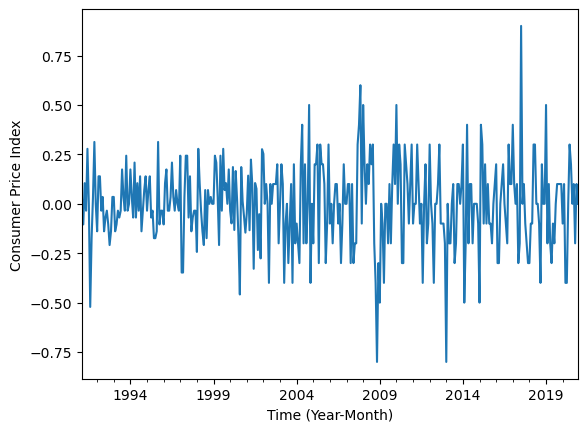

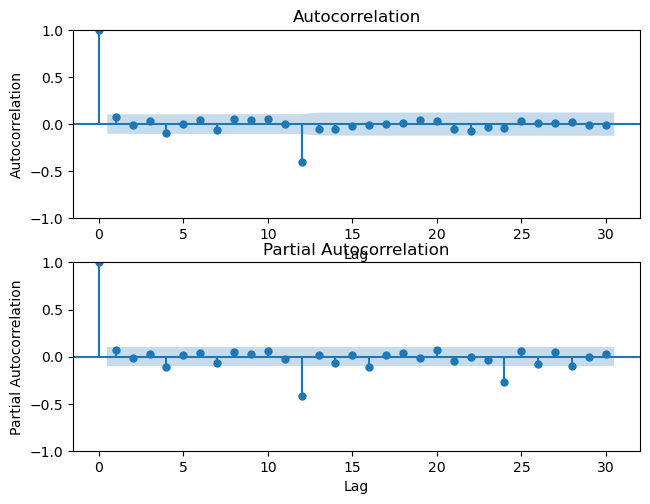

In [70]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure()
ts_diff_2.plot()
plt.ylabel('Consumer Price Index')
plt.xlabel('Time (Year-Month)')

#with plt.style.context(['science','ieee']):

fig, axs = plt.subplots(2)
fig.tight_layout()    

plot_acf(ts_diff_2,ax=axs[0],lags=30,alpha=0.05)#,markersize=2)#,lags=np.arange(ts.size/4))
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Autocorrelation')

plot_pacf(ts_diff_2,ax=axs[1],lags=30,alpha=0.05)#,markersize=2)#,lags=np.arange(ts.size/4))
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Partial Autocorrelation')

#plt.savefig('figs/acf_pacf.pdf')

plt.show()

As we can see by the slowly decaying ACS (and by the time series behaviour of course), the time series is non-stationary. Considering we also know the presence of seasonality, we will use a SARIMA model for the raw time series. Before, we applied both a first and second seasonal difference to the data, for which we found the first difference to remove the trend and the second seasonal difference of 12 samples removed the cyclic behaviour. As such, we have the orders $d=1;D=1;S=12$.

To define the orders $(p,q,P,Q)$ we now look at the ACS and PACS. Looking at the ACS and PACS between $1$ and the seasonal pattern $S=12$, we see that they both drop after $T=1$, so we assume $p=0;q=0$.

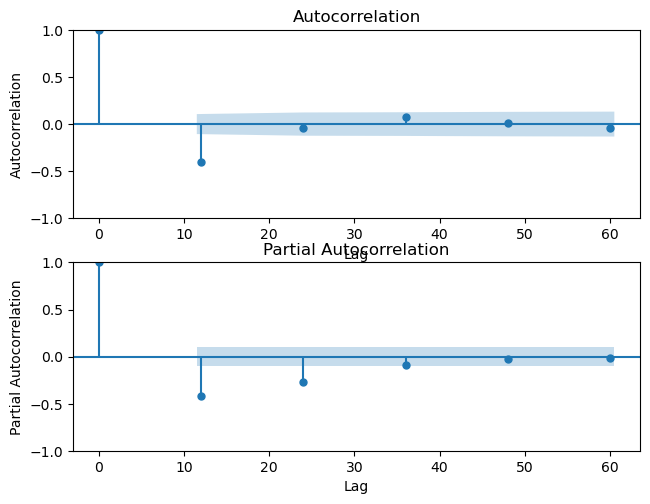

In [68]:
# with plt.style.context(['science','ieee']):
fig, axs = plt.subplots(2)
fig.tight_layout()

plot_acf(ts_diff_2,ax=axs[0],alpha=0.05, lags=range(0,70,12))#, title=None, markersize=2)#,lags=np.arange(ts.size/4))
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Autocorrelation')

plot_pacf(ts_diff_2,ax=axs[1],alpha=0.05, lags=range(0,70,12))#,title=None, markersize=2)#,lags=np.arange(ts.size/4))
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Partial Autocorrelation')

# plt.savefig('figs/sacf_spacf.pdf')

plt.show()

Given the re-sampled ACS and PACF, we can argue for $Q=1;P=2$ or even maybe $P=1$ or $P=3$. We manually test the model for these values of $P$ and results are as follows.

In [158]:
from statsmodels.tsa.arima.model import ARIMA

model_1=ARIMA(ts_train, order=(0,1,0), seasonal_order=(1,1,1,12))
fit_1 = model_1.fit()

print(f'SARIMA(0,1,0)x(1,1,1,12): {fit_1.aicc}')

SARIMA(0,1,0)x(1,1,1,12): -189.29052680080994


Let's run a grid-search to find the best possible model.

In [60]:
from itertools import product

p = range(0,2)
q = range(0,2)
P = range(0,4)
Q = range(0,3)

combs = list(product(p,q,P,Q))

res = pd.DataFrame(combs, columns=['p','q','P','Q'], dtype=np.int64)
res['AIC'] = np.zeros(len(combs))

for i,r in res.iterrows():
    model = ARIMA(ts_train, order=(r['p'],1,r['q']), seasonal_order=(r['P'],1,r['Q'],12))
    fit = model.fit()
    res.at[i,'AIC']=fit.aic

best_idx = np.argmin(res['AIC'])
print(f"Best: ({res.at[best_idx,'p']},1,{res.at[best_idx,'q']})x({res.at[best_idx,'P']},1,{res.at[best_idx,'Q']},12)")
print(f"AIC: {res.at[best_idx,'AIC']}")

c:\Users\esrpi\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\esrpi\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\esrpi\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best: (1,1,1)x(0,1,1,12)
AIC: -191.6531781741728


So, according to the grid-search, the best model is actually $(1,1,1)$ x $(0,1,1,12)$, attaining a value for the AIC of $\approx -191.7$ which is lower than the parameters derived from observing the ACS and PACS.

In [71]:
model=ARIMA(ts_train, order=(1,1,1), seasonal_order=(0,1,1,12))
fitted = model.fit()
predictions = fitted.fittedvalues
residuals = fitted.resid[1:]
residuals.name="Residuals"

In [72]:
print(fitted.summary())
print(f"RMSE: {np.sqrt(fitted.mse)}")

                                    SARIMAX Results                                     
Dep. Variable:                        Train set   No. Observations:                  372
Model:             ARIMA(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  99.827
Date:                          Wed, 07 Dec 2022   AIC                           -191.653
Time:                                  01:16:19   BIC                           -176.120
Sample:                              01-31-1990   HQIC                          -185.476
                                   - 12-31-2020                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5980      0.300     -1.994      0.046      -1.186      -0.010
ma.L1          0.6881      0.275      2.505      0.

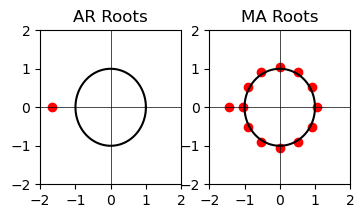

In [93]:
# plot polynomial roots
def plot_char_roots(fitted_model):

    # plt.rcParams.update({
    #     "lines.markersize": 2
    # })

    fig, axs = plt.subplots(1,2,figsize=(4,2))

    t = np.linspace(0,2*np.pi,101)
    axs[0].plot(np.cos(t),np.sin(t),color='k')

    axs[0].axhline(0,color="k", linewidth=0.5)
    axs[0].axvline(0,color="k", linewidth=0.5)

    axs[0].scatter(fitted_model.arroots.real, fitted_model.arroots.imag, c='r')
    axs[0].set_xticks(np.linspace(-2,2,5))
    axs[0].set_yticks(np.linspace(-2,2,5))

    axs[0].set_title('AR Roots')
    
    axs[1].plot(np.cos(t),np.sin(t),color='k')

    axs[1].axhline(0,color="k", linewidth=0.5)
    axs[1].axvline(0,color="k", linewidth=0.5)
    
    axs[1].scatter(fitted_model.maroots.real, fitted_model.maroots.imag, c='r')
    axs[1].set_xticks(np.linspace(-2,2,5))
    axs[1].set_yticks(np.linspace(-2,2,5))

    axs[1].set_title('MA Roots')

# with plt.style.context(['science','ieee']):

plot_char_roots(fitted)
    #plt.savefig('figs/char_roots.pdf')

# plt.show()

This shows that the polynomial roots all lie outside the unit circle, which is mandatory for assuring invertibility and stationarity of the model (residuals). However, the numbers lie to close to the unit circle, meaning they can become unstable (numerically) and lead to poor forecasts (as seen next).

Residuals Mean=-0.004916322331239439


Text(0, 0.5, 'Autocorrelation')

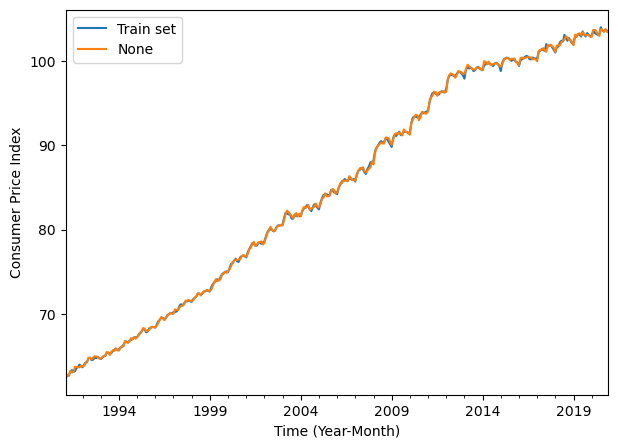

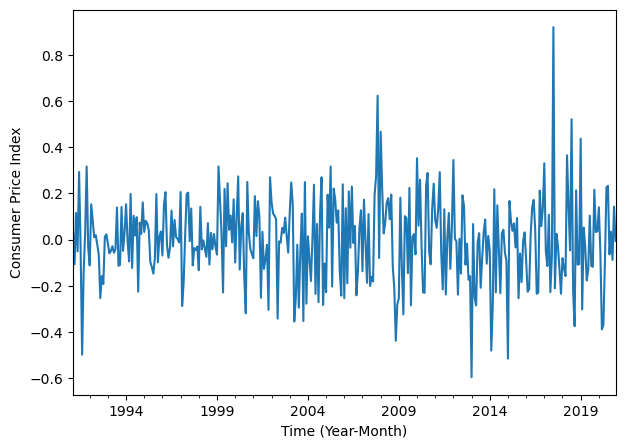

<Figure size 700x500 with 0 Axes>

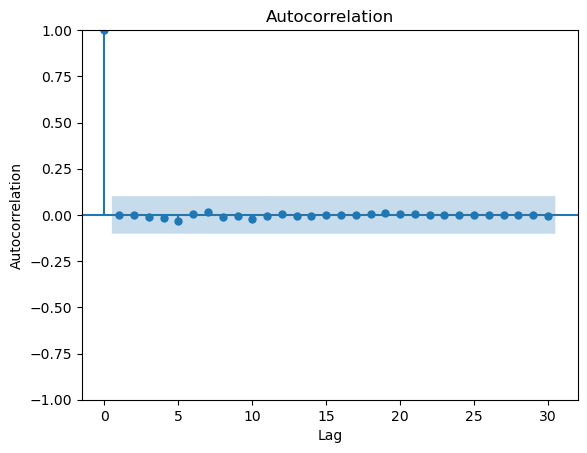

In [94]:
import scipy.stats as spyst
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(7,5))

ncoefs = 13

ts_train[ncoefs:].plot(legend=True,xlabel='Time (Year-Month)',ylabel='Consumer Price Index')
predictions[ncoefs:].plot(legend=True,xlabel='Time (Year-Month)',ylabel='Consumer Price Index')

plt.figure(figsize=(7,5))

residuals[ncoefs-1:].plot(xlabel='Time (Year-Month)',ylabel='Consumer Price Index')
print(f"Residuals Mean={residuals[ncoefs-1:].mean()}")

plt.figure(figsize=(7,5))
plot_acf(residuals, alpha=0.05, lags=30)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")

From the ACS of the attained residuals, we can argue that the mean is close to zero ($\approx -0.004$) and that the ACS is representative of an i.i.d. process. As such, we can say that the fitted model captures the process dynamics, leaving aside just the noise for the residuals.

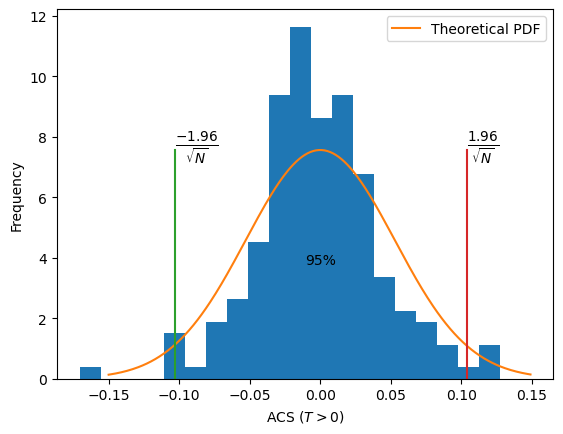

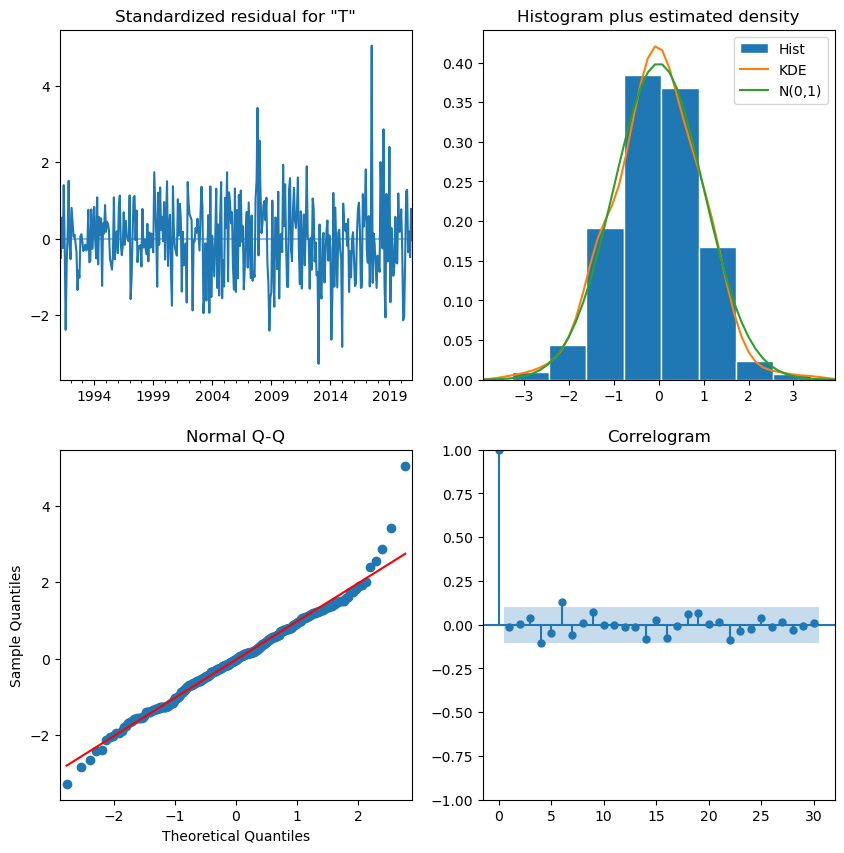

In [103]:
N = residuals[ncoefs-1:].size

residual_acf = acf(residuals[ncoefs-1:],nlags=int(N/2),fft=False)

#with plt.style.context(['science','ieee']):

plt.figure()
plt.hist(residual_acf[1:],bins=20, density=True)

rg = np.arange(-0.15,0.15,0.001)
pdf = spyst.norm.pdf(rg,0,1/np.sqrt(N))
cdf = spyst.norm.cdf(rg,0,1/np.sqrt(N))

plt.plot(rg, pdf, label='Theoretical PDF')

plt.plot([rg[np.where(cdf>=0.025)[0][0]],rg[np.where(cdf>=0.025)[0][0]]],[0,np.max(pdf)])
plt.plot([rg[np.where(cdf>=0.975)[0][0]],rg[np.where(cdf>=0.975)[0][0]]],[0,np.max(pdf)])

plt.text(rg[np.where(cdf>=0.025)[0][0]],np.max(pdf),r'$\frac{-1.96}{\sqrt{N}}$',fontsize=14)
plt.text(rg[np.where(cdf>=0.975)[0][0]],np.max(pdf),r'$\frac{1.96}{\sqrt{N}}$',fontsize=14)

plt.text(0, np.max(pdf)/2, "95%", horizontalalignment="center")

plt.ylabel('Frequency')
plt.xlabel('ACS ($T>0$)')
plt.legend()
plt.show()

#plt.savefig('figs/dist_acf.pdf')

#with plt.style.context(['science','ieee']):

fitted.plot_diagnostics(figsize=(10,10), lags=30)
#plt.savefig('figs/diag_sarima.pdf')

plt.show()

Unfortunately, we do not have a large number of samples $N=372$ samples, which, and according to the Law of Large Numbers, doesn't provide enough statistical significance for the model to perform fittings close to the expected value. We can see that the residuals are not all contained within the $0.95$% confidence bounds ($-0.05>x>0.05$). As such, we can understand that the ACS of the residuals isn't really normaly distributed with mean $=0$ and variance $\frac{1}{\sqrt{N}}$. Much because $N$ is not large enough.

### Exponential

Additionally, the timeseries can also be fitted by an exponential smoothign approch

In [104]:
from statsmodels.tsa.api import ExponentialSmoothing

grid_exp = pd.DataFrame(data=[['add','add'],['add','mul'],['mul','add'],['mul','mul']], columns=['trend','seasonal'])

AIC = np.zeros(4)
for i in range(len(grid_exp)):
    AIC[i] = ExponentialSmoothing(ts_train,trend=grid_exp.iat[i,0],seasonal=grid_exp.iat[i,1],seasonal_periods=12).fit().aicc

grid_exp['AIC'] = AIC
grid_exp.head()

,trend,seasonal,AIC
0,add,add,-1136.903678
1,add,mul,-1135.722259
2,mul,add,-1134.328854
3,mul,mul,-1133.223065


In [105]:
from itertools import product

step = 0.1
a = np.arange(step,1-step,step)
g = np.ones(a.size)*0.03 #np.arange(0.03,0.03,1) #np.arange(step,1-step,step)
d = np.arange(step,1-step,step)

combs = list(product(a,g,d))

res = pd.DataFrame(combs, columns=['a','g','d'], dtype=np.float64)
res['AIC'] = np.zeros(len(combs))

for i,r in res.iterrows():
    f = ExponentialSmoothing(ts_train,trend='add',seasonal='add',seasonal_periods=12).fit(smoothing_level=r['a'],smoothing_trend=r['g'],smoothing_seasonal=r['d'])
    res.at[i,'AIC']=f.aic

best_idx = np.argmin(res['AIC'])
print(f"Best: ({res.at[best_idx,'a']},{res.at[best_idx,'g']},{res.at[best_idx,'d']}")
print(f"AICC: {res.at[best_idx,'AIC']}")

Best: (0.8,0.03,0.30000000000000004
AICC: -1145.9825746874978


In [106]:
fitted_exp = ExponentialSmoothing(ts_train,trend='add',seasonal='add',seasonal_periods=12).fit(
    smoothing_level=0.8,
    smoothing_trend=0.03,
    smoothing_seasonal=0.3
    )
    
fitted_exp.summary()

Dep. Variable:,Train set,No. Observations:,372
Model:,ExponentialSmoothing,SSE,15.678
Optimized:,True,AIC,-1145.983
Trend:,Additive,BIC,-1083.280
Seasonal:,Additive,AICC,-1144.045
Seasonal Periods:,12,Date:,"Wed, 07 Dec 2022"
Box-Cox:,False,Time:,01:48:31
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.8000000,alpha,False
smoothing_trend,0.0300000,beta,False


## Forecasting
The following considers forecasting with a Box-Jenkins approach, iterating on the previous model

### SARIMA

<AxesSubplot:>

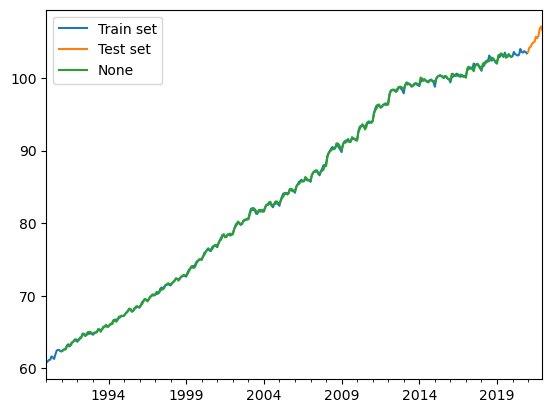

In [107]:
plt.figure()
ts_train.plot(legend=True)
ts_test.plot(legend=True)
fitted_exp.fittedvalues[12:-12].plot(legend=True)

Validation RMSE=1.5087477296430194


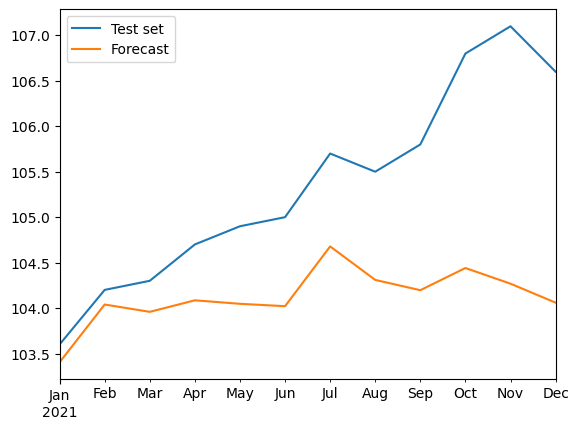

In [108]:
plt.figure()
ts_test.plot(legend=True)
forecast = fitted.forecast(ts_test.size)
forecast.name = "Forecast"
forecast.plot(legend=True)

print(f"Validation RMSE={np.sqrt(np.mean((ts_test-forecast)**2))}")

<AxesSubplot:>

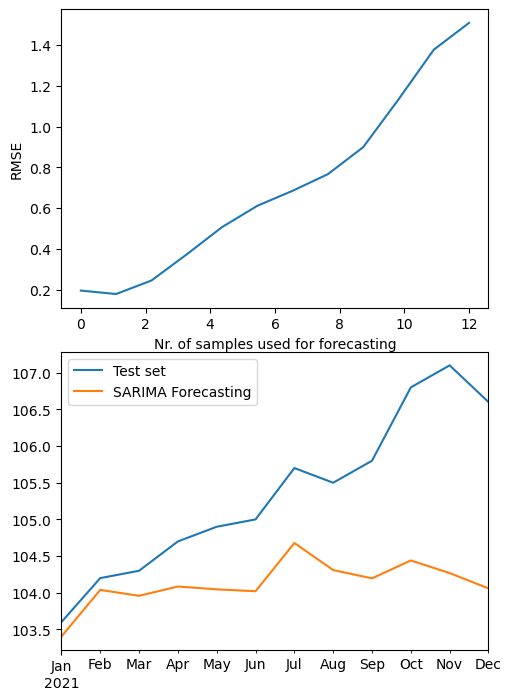

In [109]:
rmse = np.zeros(ts_test.size)

for i in range(ts_test.size):
    forecast = fitted.forecast(i+1)
    rmse[i] = np.sqrt(np.mean((ts_test[:i+1]-forecast)**2))

fig, axs = plt.subplots(2,1, figsize=(5,7))
fig.tight_layout()

axs[0].plot(np.linspace(0,ts_test.size,ts_test.size), rmse)

#axs[0].axvline(37, color='r', linestyle='--')
#axs[0].axvline(56, color='r', linestyle='--')
#axs[0].axvline(59, color='r', linestyle='--')

axs[0].set_ylabel('RMSE')
axs[0].set_xlabel('Nr. of samples used for forecasting')

ts_test.plot(ax=axs[1], legend=True)

forecast = fitted.forecast(ts_test.size)
forecast.name = "SARIMA Forecasting"
forecast.plot(ax=axs[1], legend=True)

#axs[1].axvline(ts_test.index[37], color='r', linestyle='--')
#axs[1].axvline(ts_test.index[56], color='r', linestyle='--')
#axs[1].axvline(ts_test.index[59], color='r', linestyle='--')

We can see that when increasing the number of samples forecasted, the RMSE actually increases and decreases alternatively up until (more or less) the samples marked with red vertical lines. After these, the RMSE increases slightly, and a lot more in the final samples. Looking at the original test, we can see that these are the places where the TS "breaks" a bit its pattern (for the first one, where it stays relatively steady instead of going up), and when it goes a lot faster to higher values in the next samples, for which the SARIMA model was not able to estimate/account for this almost outliers of the data, and so the RMSE goes up as well.

Nonetheless, we can say that it can actually behave really well for predicting the cyclic behaviour

Seasonal Validation RMSE=0.338680128281437
12-sample Validation RMSE=1.5087477296430194


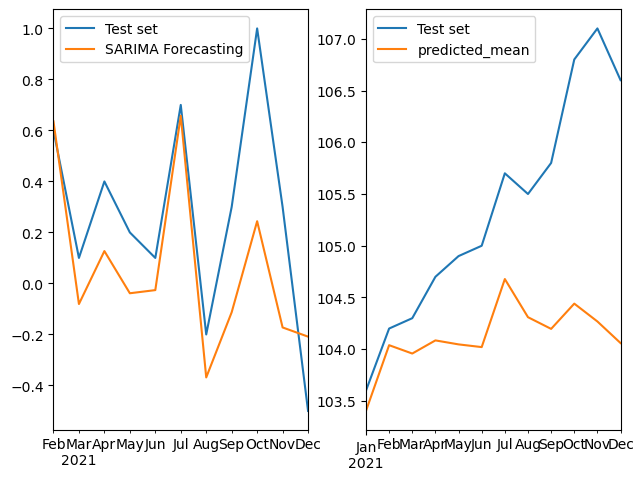

In [110]:
ts_test_diff = ts_test.diff().dropna()
forecast_diff = forecast.diff().dropna()

fig, axs = plt.subplots(1,2)
fig.tight_layout()

ts_test_diff.plot(ax=axs[0],legend=True)
forecast_diff.plot(ax=axs[0],legend=True)

ts_test[:12].plot(ax=axs[1],legend=True)
forecast_cycle = fitted.forecast(12)
forecast_cycle.plot(ax=axs[1], legend=True)

print(f"Seasonal Validation RMSE={np.sqrt(np.mean((ts_test_diff-forecast_diff)**2))}")
print(f"12-sample Validation RMSE={np.sqrt(np.mean((ts_test[:12]-forecast_cycle)**2))}")

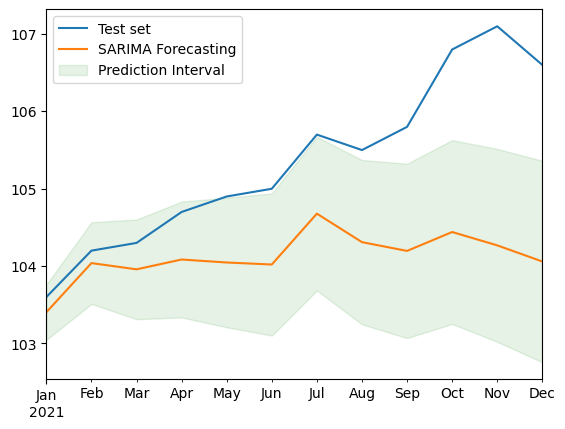

In [111]:
alpha = 0.05
pi_full = fitted.get_forecast(ts_test.size).conf_int(alpha)

ax = ts_test.plot(legend=True)
forecast.plot(ax=ax,legend=True)
plt.fill_between(pi_full.index,pi_full.iloc[:,0],pi_full.iloc[:,1],color='g',alpha=.1, label='Prediction Interval')
plt.legend()

### Exponential

Validation RMSE=1.2917993081973755


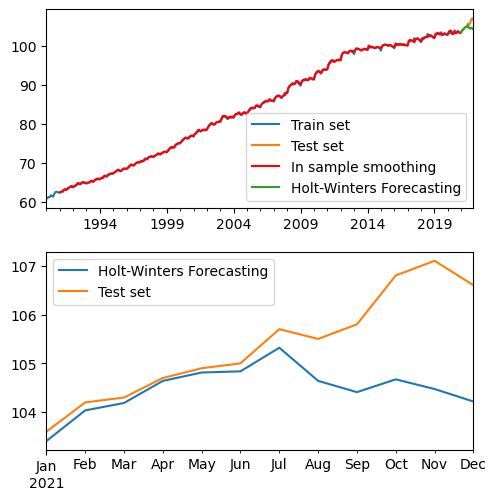

In [112]:
fig, axs = plt.subplots(2,1, figsize=(5,5))
fig.tight_layout()

ts_train.plot(ax=axs[0],legend=True)
ts_test.plot(ax=axs[0],legend=True)
insamp = fitted_exp.fittedvalues[12:]
insamp.name = "In sample smoothing"
insamp.plot(ax=axs[0],legend=True,color='r')

outsamp = fitted_exp.predict(ts_test.index[0],ts_test.index[-1])
outsamp.name = "Holt-Winters Forecasting"
outsamp.plot(ax=axs[0],legend=True)

outsamp.plot(ax=axs[1],legend=True)
ts_test.plot(ax=axs[1], legend=True)

print(f"Validation RMSE={np.sqrt(np.mean((ts_test-outsamp)**2))}")

RMSE SARIMA=1.5087477296430194
RMSE Holt-Winters=1.2917993081973755


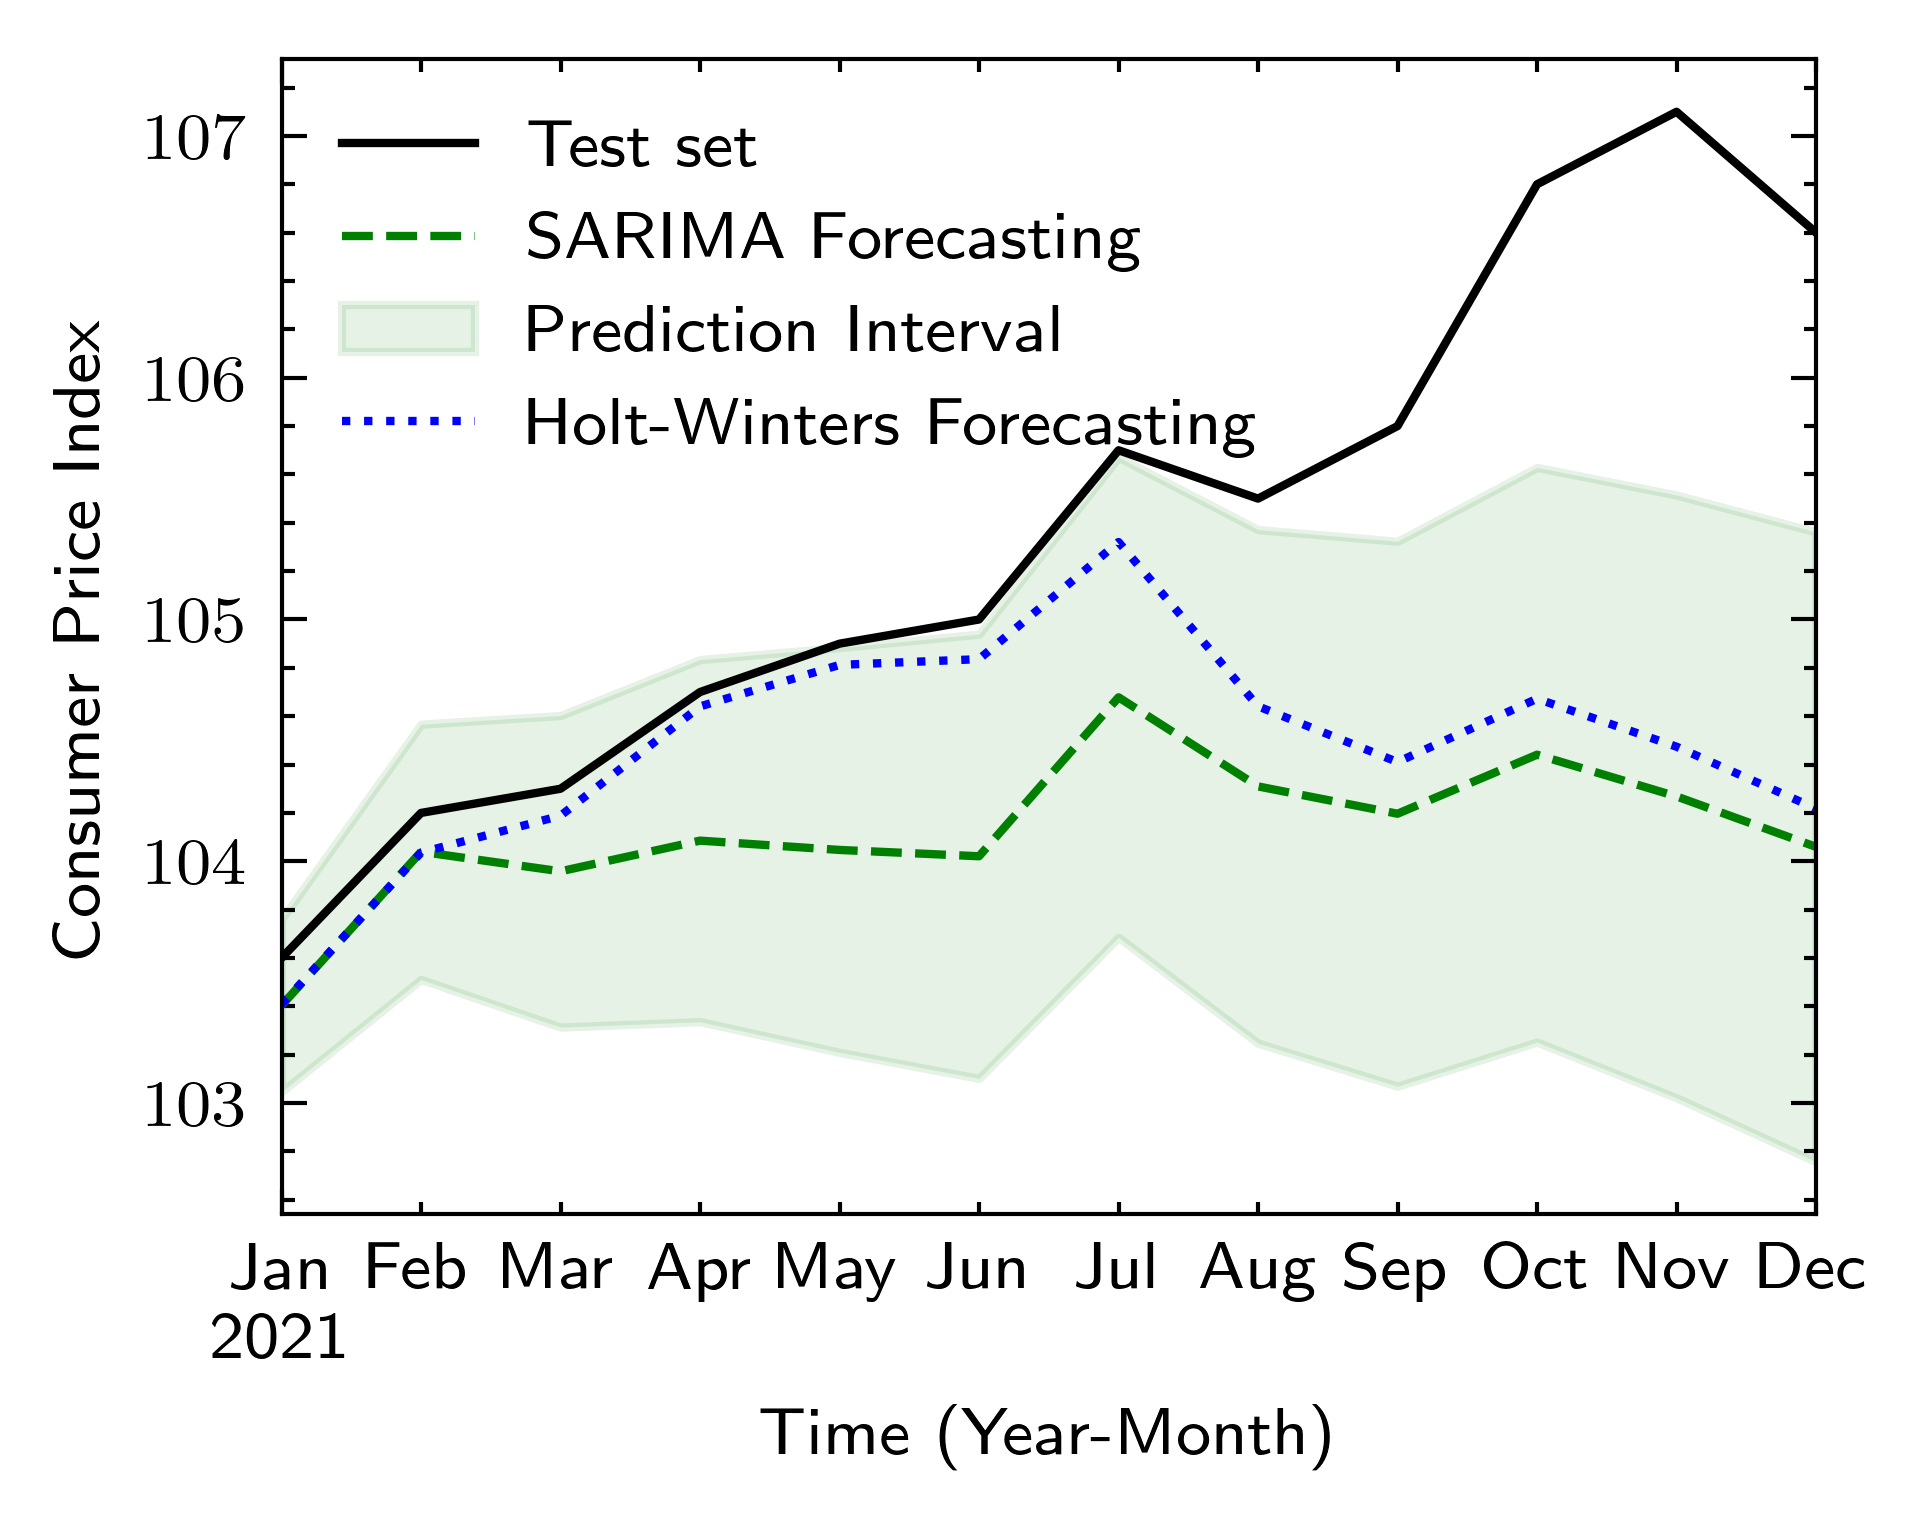

In [157]:
with plt.style.context(['science','ieee']):

    ts_test.plot(legend=True)

    forecast.plot(legend=True, color='g')
    alpha = 0.05
    pi_full = fitted.get_forecast(ts_test.size).conf_int(alpha)
    plt.fill_between(pi_full.index,pi_full.iloc[:,0],pi_full.iloc[:,1],color='g',alpha=.1, label='Prediction Interval')



    outsamp.plot(legend=True)

    plt.xlabel('Time (Year-Month)')
    plt.ylabel('Consumer Price Index')

    plt.legend()

    plt.savefig('figs/forecast.pdf')

print(f"RMSE SARIMA={np.sqrt(np.mean((ts_test-forecast)**2))}\nRMSE Holt-Winters={np.sqrt(np.mean((ts_test-outsamp)**2))}")

# Multivariate

In [135]:
ts_denmark = get_ts('Denmark', chop=8)
ts_norway = get_ts('Norway', chop=8)
ts_finland = get_ts('Finland', chop=8)

series = ['Denmark','Norway','Finland']
multi_df = pd.concat([ts_denmark,ts_norway,ts_finland], axis=1)

years_for_val = 4
ts_multi_train = multi_df[multi_df.index[0]:multi_df.index[-13]]
ts_multi_val = multi_df[multi_df.index[-(12*(1+years_for_val))]:multi_df.index[-13]]
ts_multi_test  = multi_df[multi_df.index[-12]:multi_df.index[-1]]

## ML

In [136]:
def timeseries_to_array(outData,inData=pd.DataFrame(),delayEndog=[1],delayExog=[],h=1):
    N=outData.shape[0]
    inShape=inData.shape
    if len(inShape)==1:
        M=1
    else:
        M=inShape[1]# The number of explanatory TS (Exogenous inputs)
    
    laggedData=pd.DataFrame(index=inData.index)
    for i in range(M):
        for j in range(len(delayExog[i])):
            if isinstance(inData, pd.DataFrame):
                laggedData[inData.columns[i]+'_lag'+str(delayExog[i][j]+(h-1))] = inData[inData.columns[i]].shift(periods=delayExog[i][j]+(h-1))
            else:
                laggedData[inData.name+'_lag'+str(delayExog[i][j]+(h-1))] = inData.shift(periods=delayExog[i][j]+(h-1))
    
    for j in range(len(delayEndog)):
        laggedData[outData.name+'_lag'+str(delayEndog[j]+(h-1))] = outData.shift(periods=delayEndog[j]+(h-1))
    
    laggedData[outData.name]=outData
    
    return laggedData.dropna(axis=0)
    
def array_to_tensor(data,T,M):
    dataMat=data.to_numpy()
    N=data.shape[0]
    Ti=0
    tensor=np.zeros((N,T,M))
    print(tensor.shape)
    for i in range(M):
        tensor[:,:,i]=dataMat[:,Ti:Ti+T]
        Ti=Ti+T
    
    return tensor

In [137]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(ts_multi_train)

ts_multi_train = pd.DataFrame(data=scaler.transform(ts_multi_train), index=ts_multi_train.index, columns=ts_multi_train.columns)
ts_multi_val = pd.DataFrame(data=scaler.transform(ts_multi_val), index=ts_multi_val.index, columns=ts_multi_val.columns)
ts_multi_test = pd.DataFrame(data=scaler.transform(ts_multi_test), index=ts_multi_test.index, columns=ts_multi_test.columns)

<AxesSubplot:>

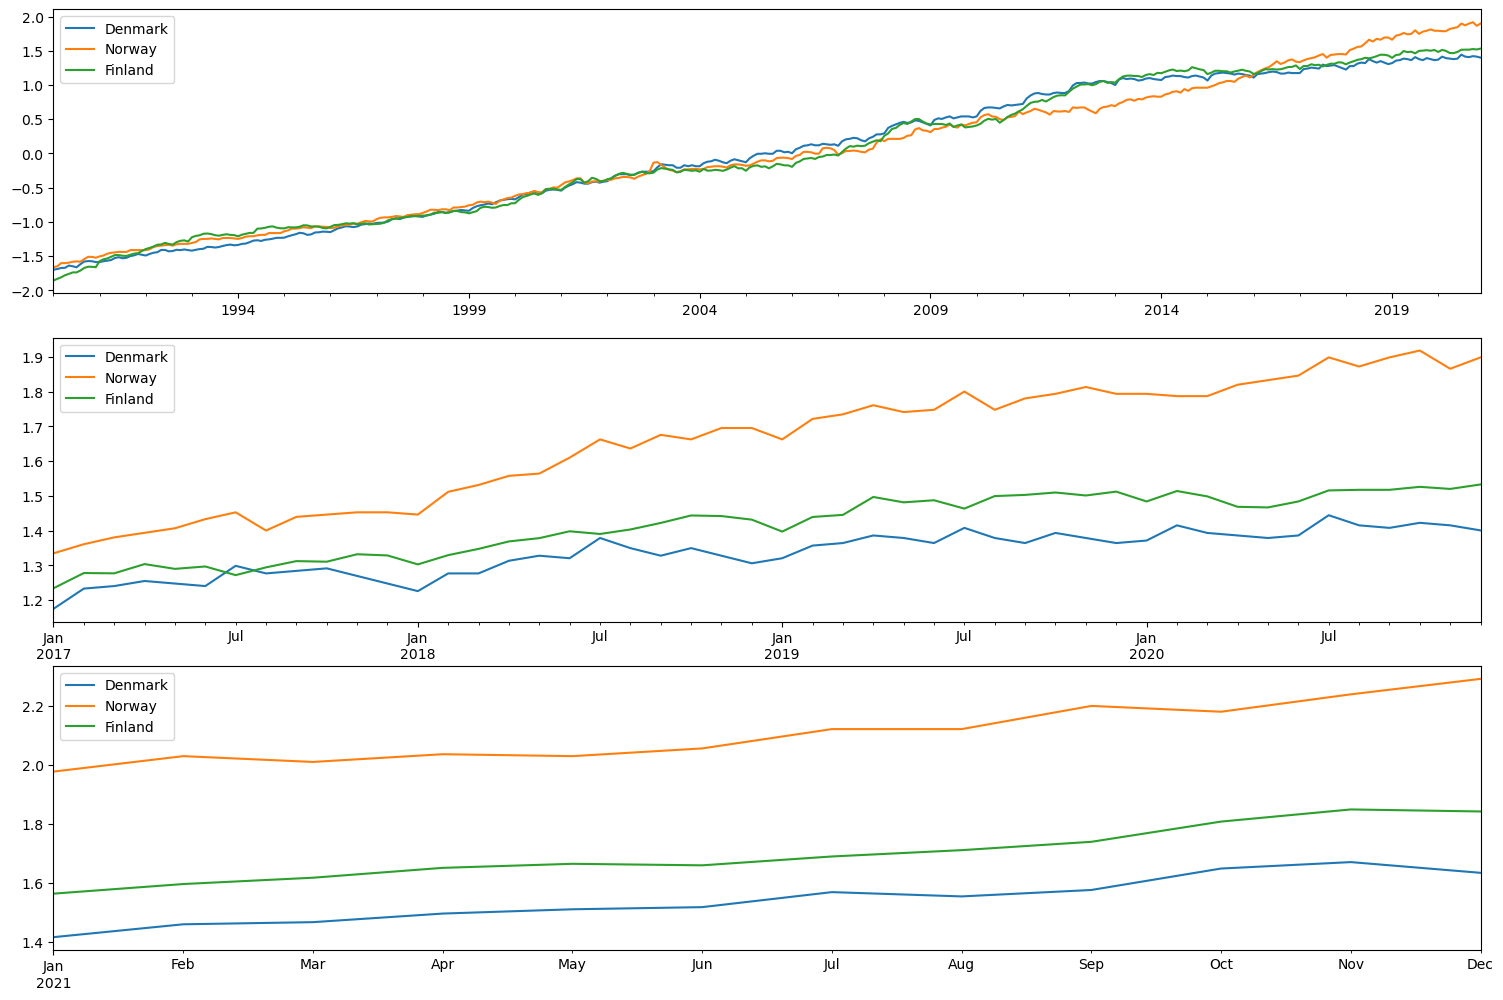

In [138]:
fig, axs = plt.subplots(3, figsize=(15,10))
fig.tight_layout()
ts_multi_train.plot(ax=axs[0], legend=True)
ts_multi_val.plot(ax=axs[1], legend=True)
ts_multi_test.plot(ax=axs[2], legend=True)

Minimum RMSE is :0.0055083852010915065
Best Delay Combination:[[[0, 1, 12], [0, 1, 12]], [1, 2, 12]]
Forecast RMSE=0.11169244928555754


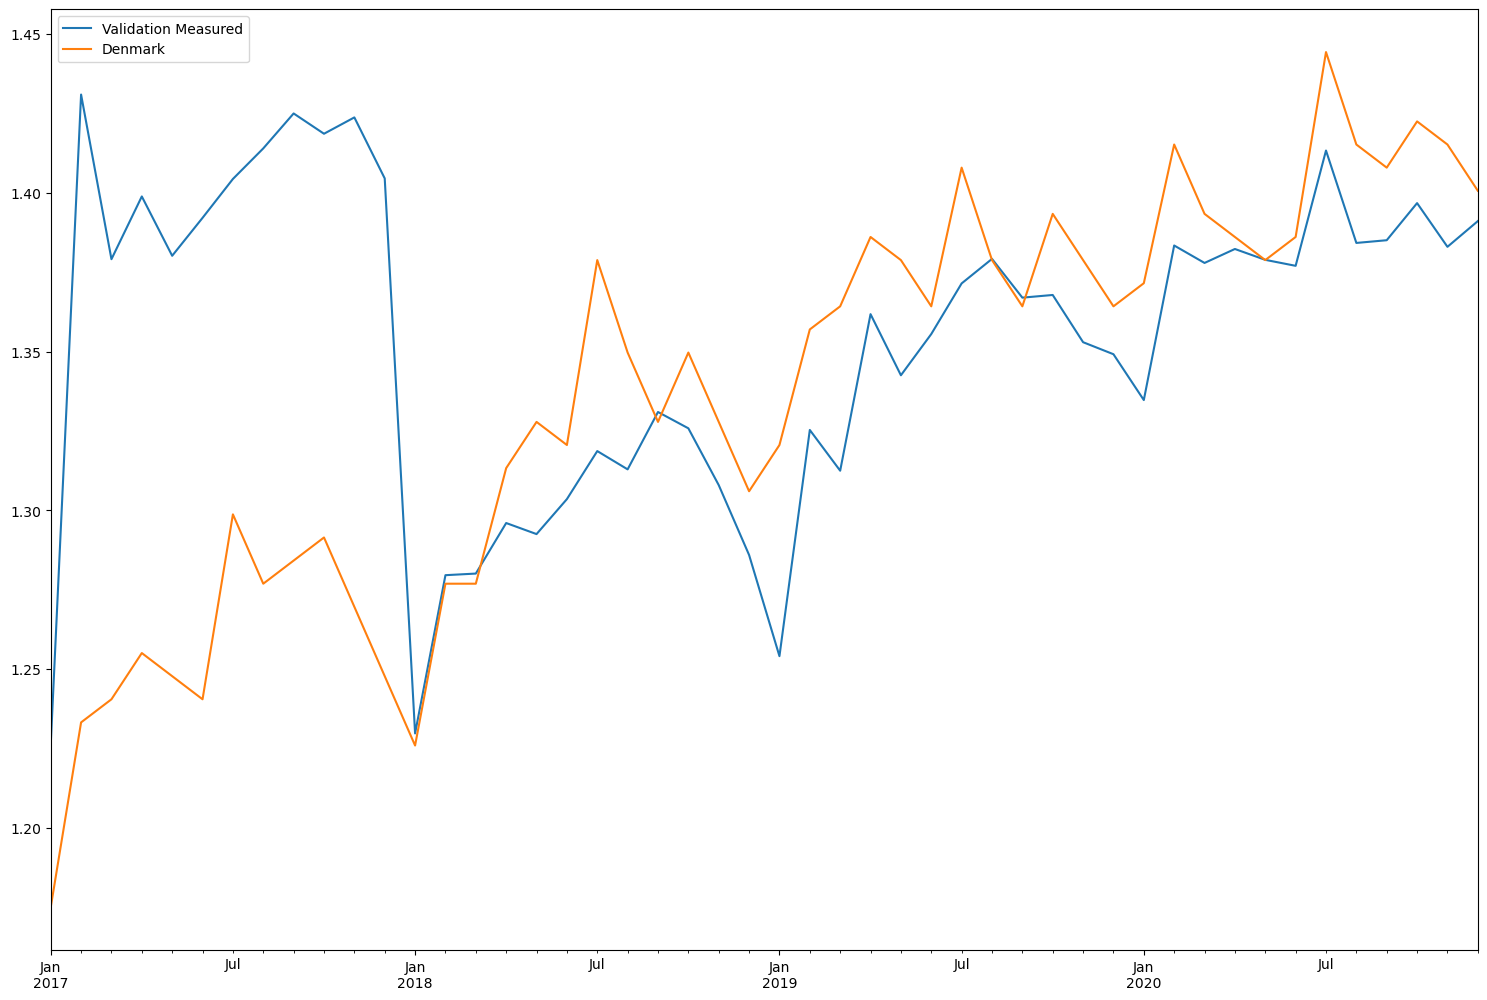

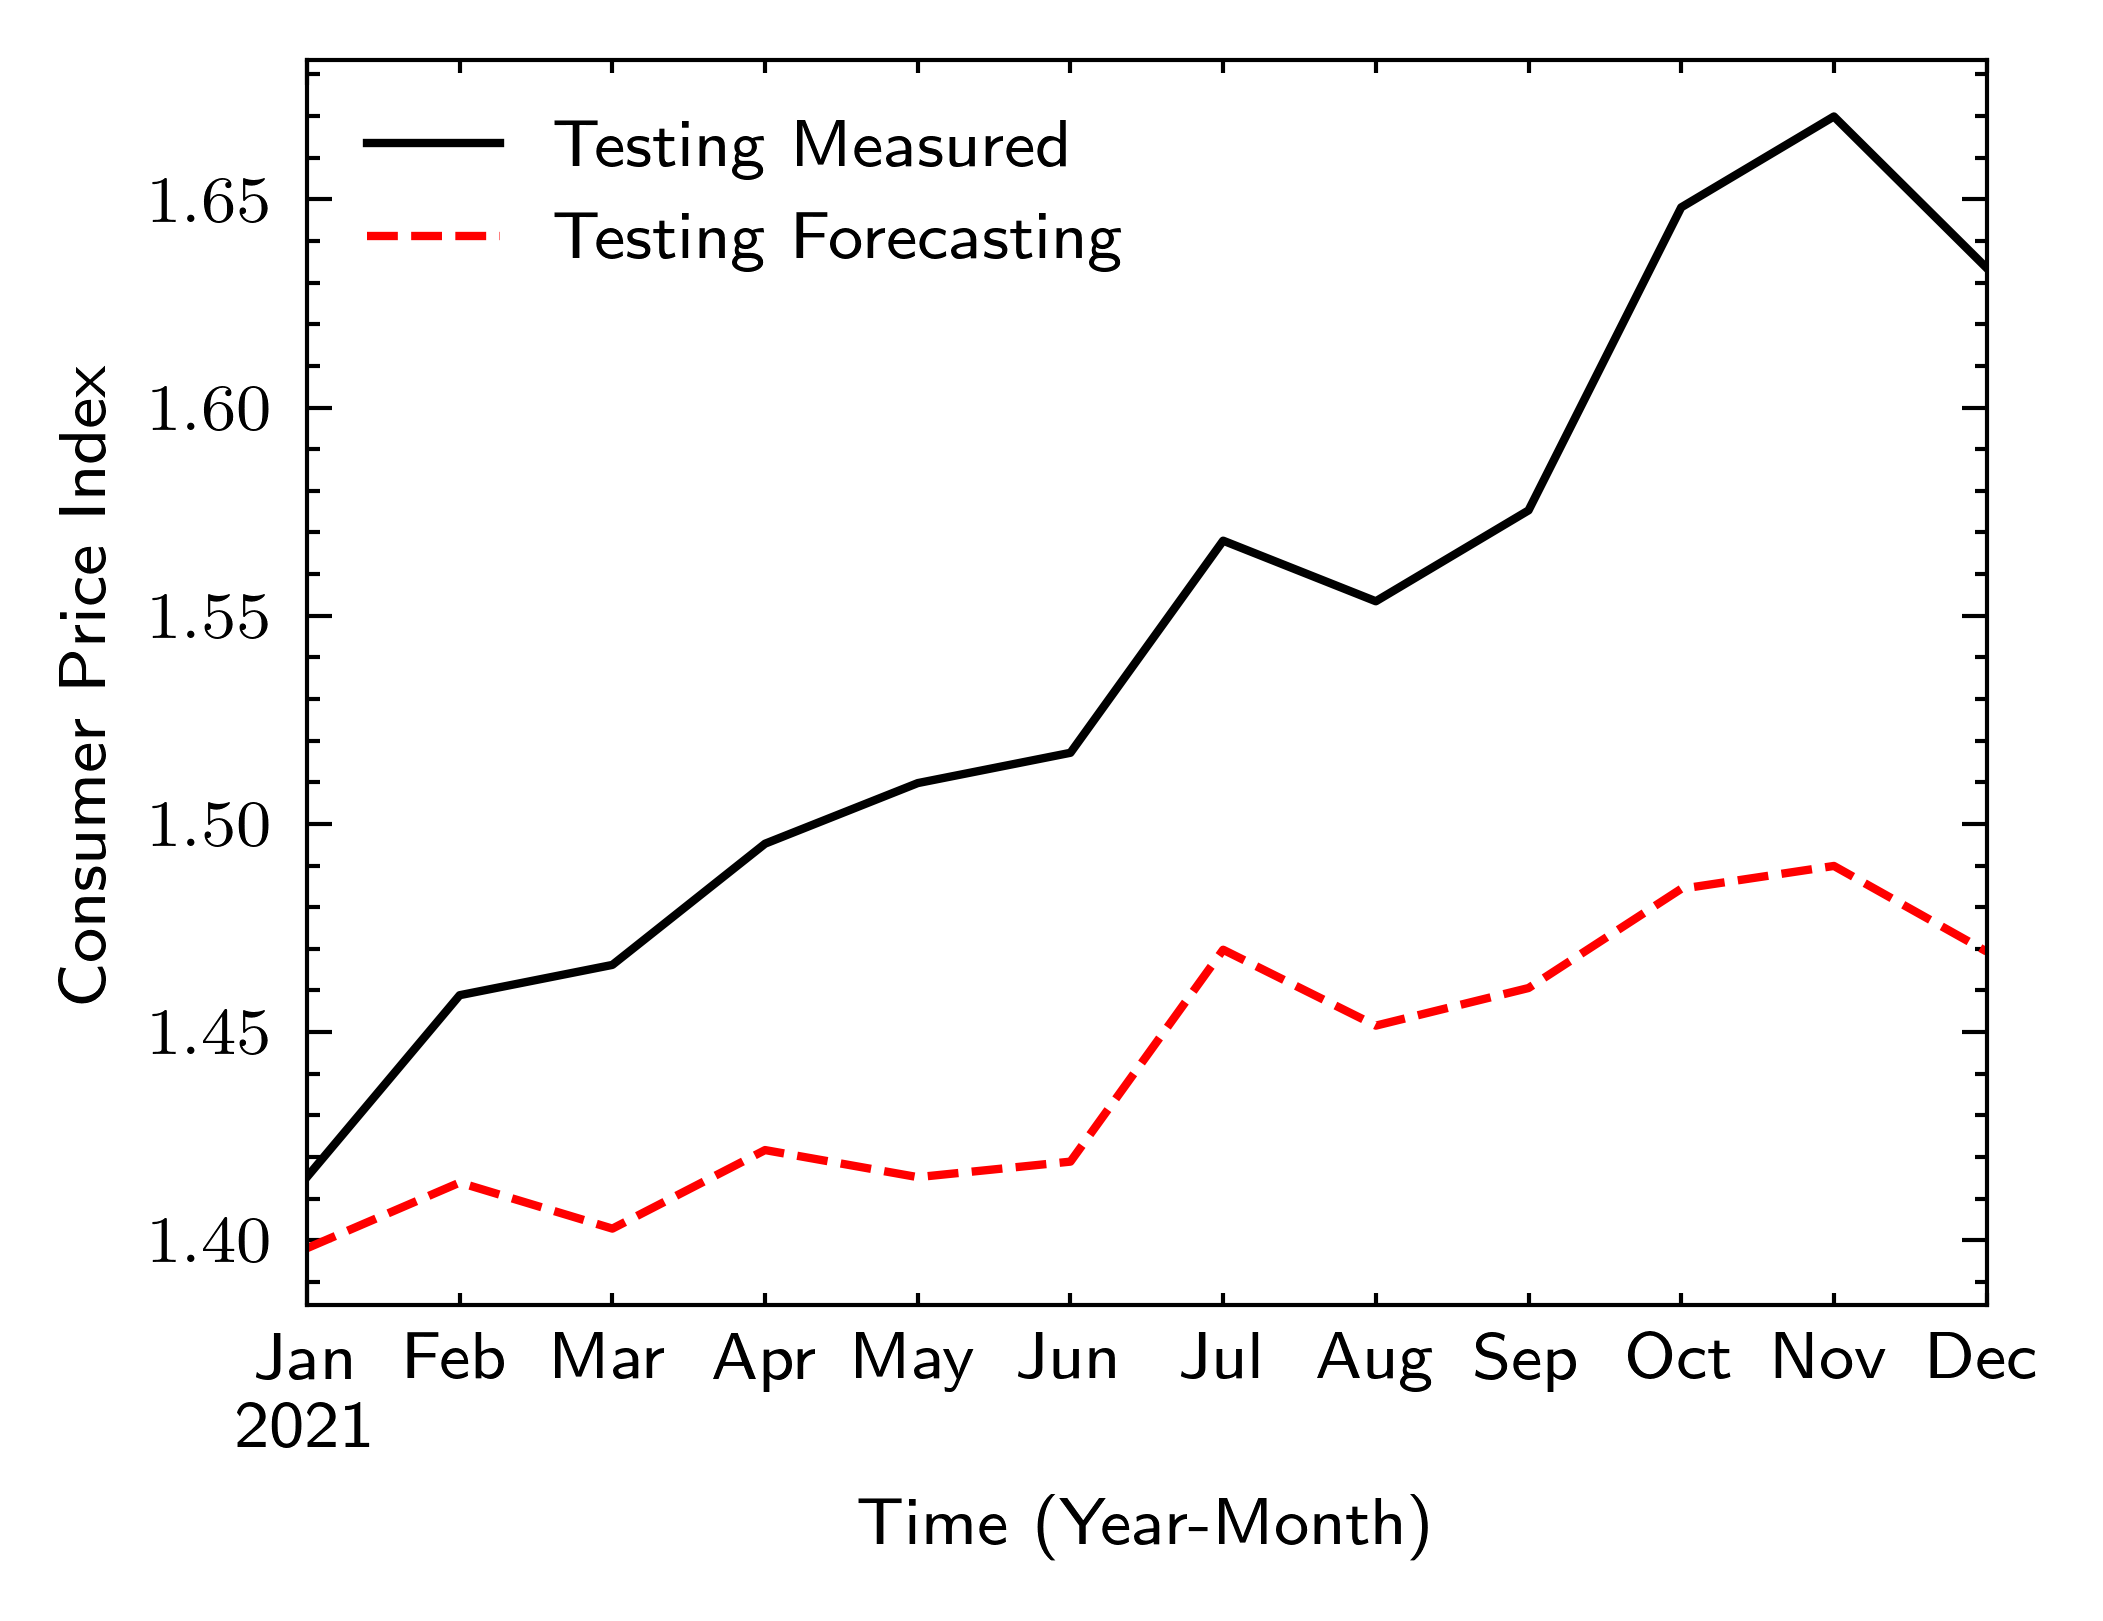

In [156]:
from sklearn.neural_network import MLPRegressor

delays=[[[[0,1],[0,1]],[1,2]],
      [[[0,1,12],[0,1,12]],[1,2,12]],
      [[[0,12],[0,12]],[1,12]]]

predicts=[]
rmses=[]
models=[]
for d in delays:
    maxdel=np.amax([np.amax(d[0]),np.amax(d[1])])#Get maximum delay for proper indexing
    
    #Generate input/output data
    data=timeseries_to_array(outData=ts_multi_train['Denmark'],inData=ts_multi_train[['Norway','Finland']],delayEndog=d[1],delayExog=d[0])
    input_train=data.iloc[:,0:-1].to_numpy()
    output_train=data.iloc[:,-1].to_numpy()
    dataTRTS=pd.Series(data=output_train,index=ts_multi_train['Denmark'].index[maxdel:],name='Training Data')
    
    #Validation data
    data_val=pd.DataFrame(pd.concat((ts_multi_train.iloc[ts_multi_train.shape[0]-maxdel:],ts_multi_val)),columns=ts_multi_val.columns)
    
    data=timeseries_to_array(outData=data_val['Denmark'],inData=data_val[['Norway','Finland']],delayEndog=d[1],delayExog=d[0])
    input_val=data.iloc[:,0:-1].to_numpy()
    output_val=data.iloc[:,-1].to_numpy()
    dataVLTS=pd.Series(data=output_val,index=data.index,name='Val Data')
    
    
    #Implement a MLP regressor
    regr = MLPRegressor(random_state=1, max_iter=5000,early_stopping=True,
                        hidden_layer_sizes=(10,)).fit(input_train, output_train)

    models.append(regr)
    #Evaluate Validation forecasting and error
    predictVLTS=pd.Series(data=regr.predict(input_val),index=dataVLTS.index,name='Validation Measured')
    predicts.append(predictVLTS)
    resTS=dataVLTS-predictVLTS
    resTS.name='Validation Forecasting'                       
    rmses.append((np.sum((resTS.to_numpy())**2))/resTS.size)
    
ix=np.where(rmses==np.min(rmses))[0][0]
print('Minimum RMSE is :'+str(rmses[ix]))
print('Best Delay Combination:'+str(delays[ix]))
#Lets plot best Val error
fig, axs=plt.subplots(1,figsize=(15,10))
fig.tight_layout()
predicts[ix].plot(ax=axs,legend=True)
ts_multi_val['Denmark'].plot(ax=axs,legend=True)


#Testing performance
#Testing data preparation
d=delays[ix]
maxdel=np.amax([np.amax(d[0]),np.amax(d[1])])#Get maximum delay for proper indexing
data_test=pd.DataFrame(pd.concat((ts_multi_val.iloc[ts_multi_val.shape[0]-maxdel:],ts_multi_test)),columns=ts_multi_test.columns)
data=timeseries_to_array(outData=data_test['Denmark'],inData=data_test[['Norway','Finland']],delayEndog=d[1],delayExog=d[0])
input_test=data.iloc[:,0:-1].to_numpy()
output_test=data.iloc[:,-1].to_numpy()
dataTETS=pd.Series(data=output_test,index=data.index,name='Testing Measured')


with plt.style.context(['science','ieee']):

#Plot forecasting in testing
    forecastTETS=pd.Series(data=models[ix].predict(input_test),index=dataTETS.index,name='Testing Forecasting')
    fig, axs=plt.subplots(1,)
    fig.tight_layout()
    #dataTRTS.plot(legend=True)
    dataTETS.plot(ax=axs,legend=True)
    forecastTETS.plot(ax=axs,legend=True)
    plt.ylabel('Consumer Price Index')
    plt.xlabel('Time (Year-Month)')

    plt.savefig('figs/multi_forecast.pdf')

print("Forecast RMSE="+str(np.sqrt(np.sum((dataTETS-forecastTETS)**2)/forecastTETS.size)))

In [153]:
from sklearn.metrics import r2_score,mean_squared_error

preds = models[ix].predict(input_test)
print(f'R2: {r2_score(output_test, preds)}')
print(f'MSE: {mean_squared_error(output_test, preds)}')

R2: -1.1233651308446184
MSE: 0.01247520322740684


## Cross-Correlation Function 

In [126]:
def crosscov(timeserie1,timeserie2,T=0):
    N=np.array([timeserie1.size,timeserie2.size]).min()
    mu1=timeserie1.mean()
    mu2=timeserie2.mean()
    covCoef=0
    for n in range(0,N-T-1):
        covCoef=covCoef+(timeserie1[n]-mu1)*(timeserie2[n+T]-mu2)
    return covCoef/float(np.abs(N))
        

def crosscoef(timeserie1,timeserie2,T=0):
    s1=timeserie1.std()
    s2=timeserie2.std()
    return crosscov(timeserie1,timeserie2,T)/(s1*s2)

def ccs(timeserie1,timeserie2,maxT,twoside=False):
    N=np.array([timeserie1.size,timeserie2.size]).min()
    if twoside:
        corrl=np.zeros(2*maxT+1)
        ix=np.array(range(maxT+1))
        ix=np.concatenate((-np.flip(ix[1:]),ix),axis=0)
    else:
        corrl=np.zeros(maxT+1)  
        ix=np.array(range(maxT+1))
    
    for i in range(maxT+1):
        if twoside:
            if i==0:
                corrl[i+maxT]=crosscoef(timeserie1,timeserie2,i);
            else:
                corrl[i+maxT]=crosscoef(timeserie1,timeserie2,i);
                corrl[maxT-i]=crosscoef(timeserie2,timeserie1,i);
        else:
            corrl[i]=crosscoef(timeserie1,timeserie2,i);
    d = {'CCS':corrl, 'upsig':np.ones(maxT+1)*(1.96/np.sqrt(N)),
         'dnsig':-np.ones(maxT+1)*(1.96/np.sqrt(N))}
    corrl=pd.DataFrame(data=d,index=ix)
    return corrl

def compute_change(ts, name):
    inov=np.zeros(ts.size-1)
    for i in range(1,ts.size):
        inov[i-1]=((ts.iloc[i]/ts.iloc[i-1])-1)*100
    return pd.Series(data=inov,index=ts.index[1:],name=name)

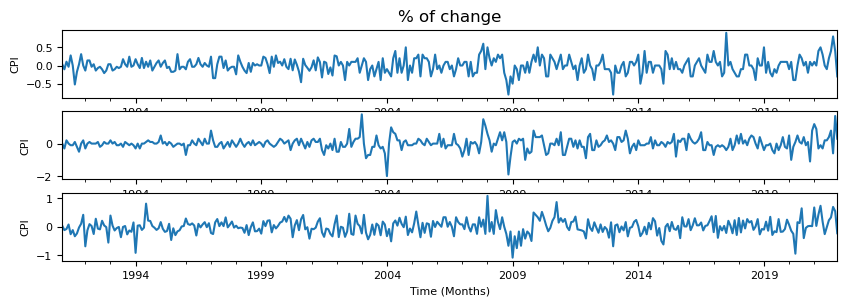

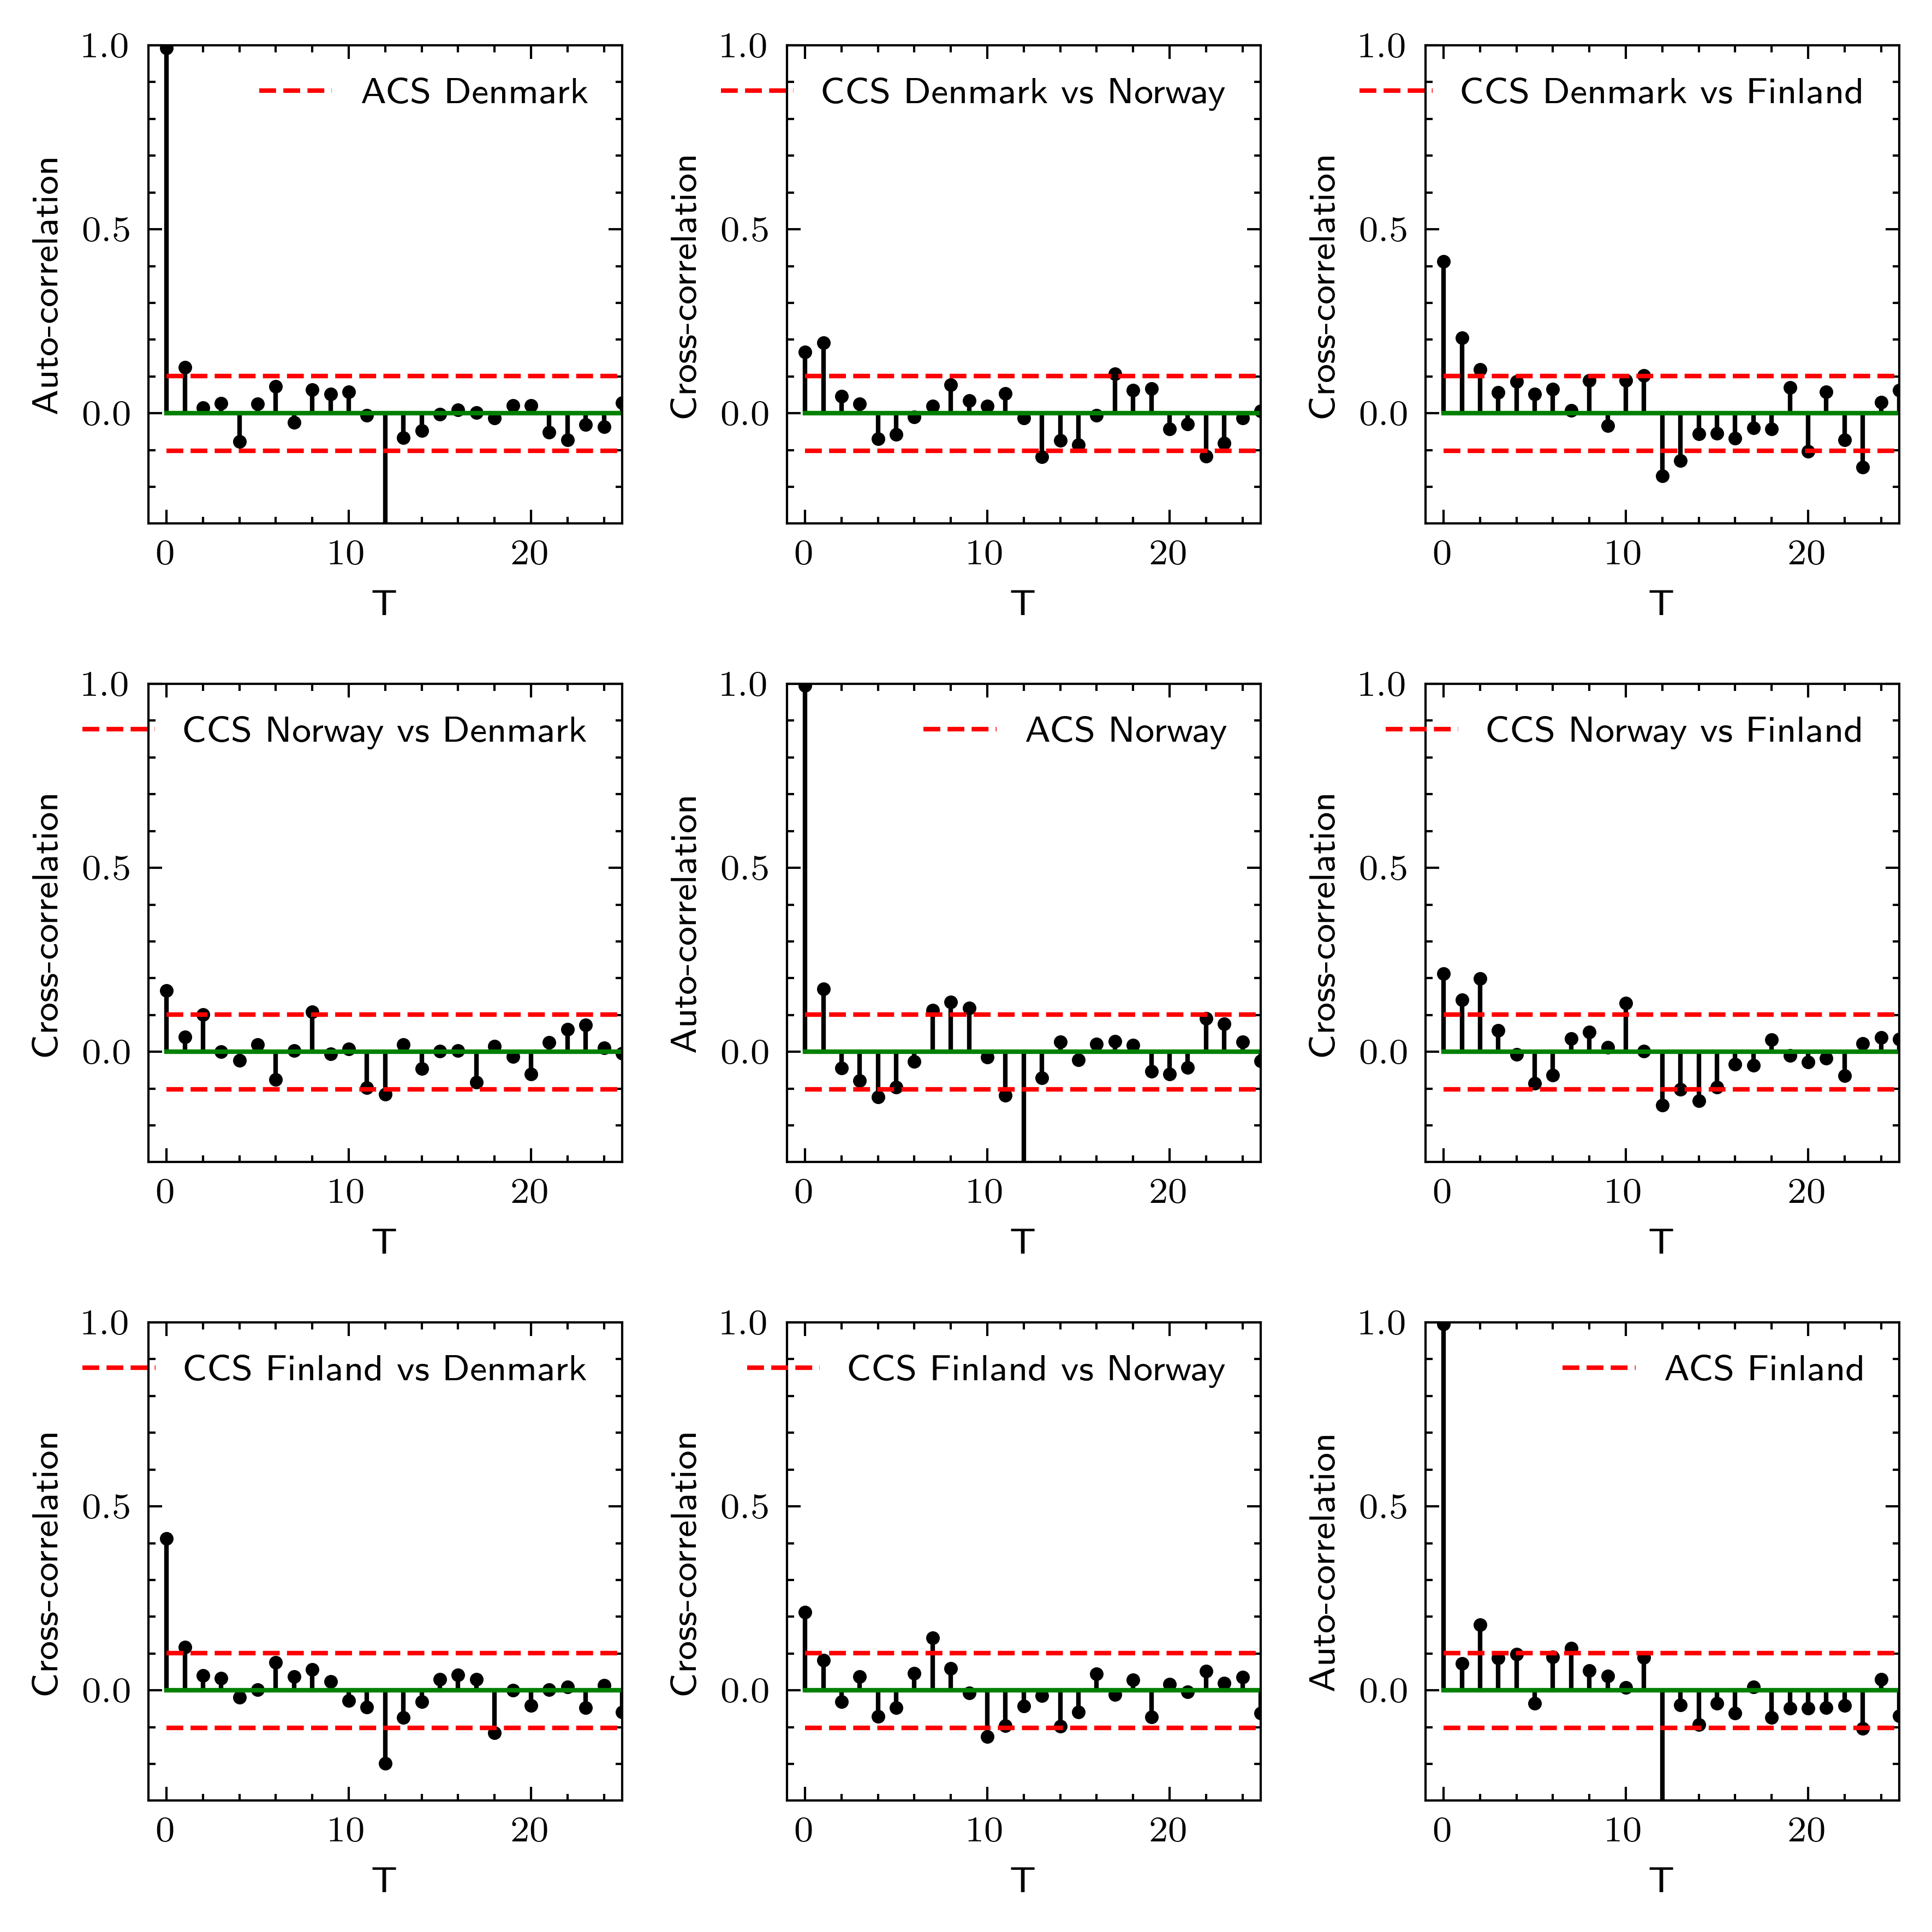

In [134]:
ts_denmark_ch=ts_denmark.diff().dropna().diff(12).dropna()#compute_change(ts_denmark,name='Denmark')
ts_norway_ch=ts_norway.diff().dropna().diff(12).dropna()#compute_change(ts_norway,name='Norway')
ts_finland_ch=ts_finland.diff().dropna().diff(12).dropna()#compute_change(ts_finland,name='Finland')

lags = 25

fig, axs=plt.subplots(3,figsize=(10,10))
ts_denmark_ch.plot(ax=axs[0],fontsize=8,figsize=(10,3))
axs[0].set_ylabel('CPI',fontdict={'fontsize':8})
axs[0].set_xlabel('Time (Months)',fontdict={'fontsize':8}) 
axs[0].set_title('% of change') 
ts_norway_ch.plot(ax=axs[1],fontsize=8,figsize=(10,3))
axs[1].set_ylabel('CPI',fontdict={'fontsize':8})
axs[1].set_xlabel('Time (Months)',fontdict={'fontsize':8})   
ts_finland_ch.plot(ax=axs[2],fontsize=8,figsize=(10,3))
axs[2].set_ylabel('CPI',fontdict={'fontsize':8})
axs[2].set_xlabel('Time (Months)',fontdict={'fontsize':8}) 

with plt.style.context(['science','ieee']):

    plt.rcParams.update({
        "lines.markersize": "2"
    })

    figs,axs=plt.subplots(3,3, tight_layout=True,figsize=(6,6))
    corrl=ccs(ts_denmark_ch,ts_denmark_ch,maxT=lags)
    corrl.name='ACS Denmark'
    axs[0,0].stem(corrl.index,corrl['CCS'])
    axs[0,0].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=1)
    axs[0,0].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=1)
    axs[0,0].set_xlabel("T")
    axs[0,0].set_ylabel("Auto-correlation")
    axs[0,0].legend([corrl.name])
    axs[0,0].axis([-1,lags,-0.3,1])

    corrl=ccs(ts_denmark_ch,ts_norway_ch,maxT=lags)
    corrl.name='CCS Denmark vs Norway'
    axs[0,1].stem(corrl.index,corrl['CCS'])
    axs[0,1].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=1)
    axs[0,1].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=1)
    axs[0,1].set_xlabel("T")
    axs[0,1].set_ylabel("Cross-correlation")
    axs[0,1].legend([corrl.name])
    axs[0,1].axis([-1,lags,-0.3,1])

    corrl=ccs(ts_denmark_ch,ts_finland_ch,maxT=lags)
    corrl.name='CCS Denmark vs Finland'
    axs[0,2].stem(corrl.index,corrl['CCS'])
    axs[0,2].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=1)
    axs[0,2].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=1)
    axs[0,2].set_xlabel("T")
    axs[0,2].set_ylabel("Cross-correlation")
    axs[0,2].legend([corrl.name])
    axs[0,2].axis([-1,lags,-0.3,1])

    corrl=ccs(ts_norway_ch,ts_denmark_ch,maxT=lags)
    corrl.name='CCS Norway vs Denmark'
    axs[1,0].stem(corrl.index,corrl['CCS'])
    axs[1,0].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=1)
    axs[1,0].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=1)
    axs[1,0].set_xlabel("T")
    axs[1,0].set_ylabel("Cross-correlation")
    axs[1,0].legend([corrl.name])
    axs[1,0].axis([-1,lags,-0.3,1])

    corrl=ccs(ts_norway_ch,ts_norway_ch,maxT=lags)
    corrl.name='ACS Norway'
    axs[1,1].stem(corrl.index,corrl['CCS'])
    axs[1,1].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=1)
    axs[1,1].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=1)
    axs[1,1].set_xlabel("T")
    axs[1,1].set_ylabel("Auto-correlation")
    axs[1,1].legend([corrl.name])
    axs[1,1].axis([-1,lags,-0.3,1])

    corrl=ccs(ts_norway_ch,ts_finland_ch,maxT=lags)
    corrl.name='CCS Norway vs Finland'
    axs[1,2].stem(corrl.index,corrl['CCS'])
    axs[1,2].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=1)
    axs[1,2].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=1)
    axs[1,2].set_xlabel("T")
    axs[1,2].set_ylabel("Cross-correlation")
    axs[1,2].legend([corrl.name])
    axs[1,2].axis([-1,lags,-0.3,1])

    corrl=ccs(ts_finland_ch,ts_denmark_ch,maxT=lags)
    corrl.name='CCS Finland vs Denmark'
    axs[2,0].stem(corrl.index,corrl['CCS'])
    axs[2,0].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=1)
    axs[2,0].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=1)
    axs[2,0].set_xlabel("T")
    axs[2,0].set_ylabel("Cross-correlation")
    axs[2,0].legend([corrl.name])
    axs[2,0].axis([-1,lags,-0.3,1])

    corrl=ccs(ts_finland_ch,ts_norway_ch,maxT=lags)
    corrl.name='CCS Finland vs Norway'
    axs[2,1].stem(corrl.index,corrl['CCS'])
    axs[2,1].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=1)
    axs[2,1].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=1)
    axs[2,1].set_xlabel("T")
    axs[2,1].set_ylabel("Cross-correlation")
    axs[2,1].legend([corrl.name])
    axs[2,1].axis([-1,lags,-0.3,1])


    corrl=ccs(ts_finland_ch,ts_finland_ch,maxT=lags)
    corrl.name='ACS Finland'
    axs[2,2].stem(corrl.index,corrl['CCS'])
    axs[2,2].plot(corrl.index,corrl['upsig'],linestyle='--', color='r', linewidth=1)
    axs[2,2].plot(corrl.index,corrl['dnsig'],linestyle='--', color='r', linewidth=1)
    axs[2,2].set_xlabel("T")
    axs[2,2].set_ylabel("Auto-correlation")
    axs[2,2].legend([corrl.name])
    axs[2,2].axis([-1,lags,-0.3,1])

    plt.savefig('figs/cross_correlation_seq.pdf')